In [92]:
import glob
import re
from datetime import datetime
from typing import Tuple

import cartopy
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywsra
import scipy
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [93]:
#TODO: import littlebuoysbigwaves (after packaging)

Plot configuration

In [94]:
IMAGE_FILE_TYPE = 'png'
IMAGE_RESOLUTION = 400 # DPI
PROJECTION = cartopy.crs.PlateCarree()

plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Helvetica" #"Arial"
# plt.rcParams["figure.autolayout"] = True

### Read the ATOMIC data
See Pincus et al. (2021) and Quinn et al. (2020).

https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:ATOMIC-2020

In [95]:
ATOMIC_PATH = '../../data/ATOMIC/'

In [96]:
def read_swift_directory(path: str) -> dict:
    """Helper function to read a directory of SWIFT .nc files.

    Returns a dictionary of xarray Datasets. Requires 'SWIFT[id]' to be
    in the individual filenames.
    """
    filenames = glob.glob(path + "/*.nc")
    swifts = {}
    for file in filenames:
        swift_id = re.search('SWIFT[0-9]{2}', file).group()
        swifts[swift_id] = xr.open_dataset(file)

    return swifts

def read_waveglider_directory(path: str) -> dict:
    """Helper function to read a directory of Wave Glider .nc files.

    Returns a dictionary of xarray Datasets. Requires 'WG[id]' to be
    in the individual filenames.
    """
    filenames = glob.glob(path + "/*.nc")
    wave_gliders = {}
    for file in filenames:
        wave_glider_id = re.search('WG[0-9]+', file).group()
        wave_gliders[wave_glider_id] = xr.open_dataset(file)

    return wave_gliders

In [97]:
atomic_wsra = pywsra.read_wsra_directory(ATOMIC_PATH + 'WSRA/', concat=True)
atomic_swifts = read_swift_directory(ATOMIC_PATH + 'SWIFT/')
atomic_wave_gliders = read_waveglider_directory(ATOMIC_PATH + 'Wave_Gliders/')
atomic_ship = xr.open_dataset(ATOMIC_PATH + 'ship' + '/EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc')

### Calculations

#### Year month day
Create a new variable corresponding to the year-month-day (ymd).

In [98]:
datetimes = pd.to_datetime(atomic_wsra['time'].values)
dates = datetimes.strftime('%Y-%m-%d')
atomic_wsra['ymd'] = (['trajectory'], dates)

In [99]:
def datetime64_to_ymd(time):
    return pd.to_datetime(time).strftime('%Y-%m-%d')

In [100]:
atomic_wsra['ymd'] = (['trajectory'],
                      datetime64_to_ymd(atomic_wsra['time'].values))
for swift_id, swift_ds in atomic_swifts.items():
    swift_ds['ymd'] = (['time'],
                        datetime64_to_ymd(swift_ds['time'].values))

#### Energy-weighted mean direction
Calculate energy-weighted mean direction

In [101]:
def spectral_moment(energy, freq=None, n=0):
    """
    Function to compute 'nth' spectral moment

    Input:
        - energy, input array of energy densities ([n,1] arr OR [n,m] ndarr)
        - freq, input array of angular_frequencies ([n,1] arr OR [n,m] ndarr)
        - n, moment ([1,] int)

    Output:
        - mn, nth spectral moment ([1,] float)
            * if energy is empty or invalid, mn is assigned a NaN

    Example:

    Compute 4th spectral moment:
        m4 = spectral_moment(energy, freq, n=4)
    """
    if hasattr(energy, '__len__') and (not isinstance(energy, str)):
        # m_n = np.trapz(np.multiply(energy,freq**n),x=freq)
        fn = np.power(freq, n)
        mn = np.trapz(energy * fn, x=freq)  # axis=1

    else:
        mn = np.NaN
    return mn

def energy_weighted_mean(X, energy_density, frequency):
    """TODO:"""
    m0 = spectral_moment(energy_density, frequency, n=0)
    weighted_integral = np.trapz(y=energy_density*X, x=frequency)
    return np.divide(weighted_integral, m0)

def direction(a1, b1):
    """TODO: from Spotter Technical Reference Manual"""
    return (90 - np.rad2deg(np.arctan2(b1,a1))) % 360

In [102]:
for swift_id, swift_ds in atomic_swifts.items():
    energy = swift_ds['energy'].values.T
    energy[np.isnan(energy)] = 0
    frequency = swift_ds['freq'].values
    frequency = np.outer(np.ones(energy.shape[0]), frequency)

    a1_weighted = energy_weighted_mean(swift_ds['a1'].values.T, energy, frequency)
    b1_weighted = energy_weighted_mean(swift_ds['b1'].values.T, energy, frequency)
    swift_ds['mean_direction'] = ('time', direction(a1_weighted, b1_weighted))

(0.0, 360.0)

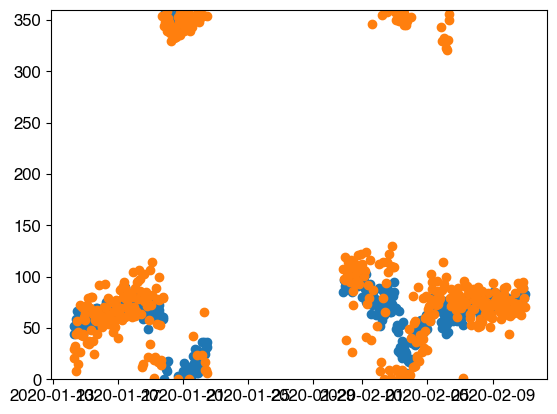

In [103]:
figure, ax = plt.subplots()
ax.scatter(swift_ds['time'], swift_ds['mean_direction'])
ax.scatter(swift_ds['time'], swift_ds['sea_surface_wave_from_direction_at_variance_spectral_density_maximum'])
ax.set_ylim([0, 360])


#### Wind and wave component vectors
Calculate wind and wave component vectors

In [104]:
def mag_and_dir_to_components(magnitude, direction, coming_from=True):
    if coming_from == True:
        sign = -1
    else:
        sign = 1
    u = sign * magnitude * np.sin(np.deg2rad(direction))
    v = sign * magnitude * np.cos(np.deg2rad(direction))
    return u, v

In [105]:
#TODO: use wave period here?
atomic_wsra['wave_u'], atomic_wsra['wave_v'] = mag_and_dir_to_components(
    magnitude=atomic_wsra['sea_surface_wave_significant_height'],
    direction=atomic_wsra['dominant_wave_direction'],
    coming_from=False,
)

for swift_id, swift_ds in atomic_swifts.items():

    swift_ds['wave_u'], swift_ds['wave_v'] = mag_and_dir_to_components(
        magnitude=swift_ds['sea_surface_wave_significant_height'],
        direction=swift_ds['mean_direction'],
        # direction=swift_ds['sea_surface_wave_from_direction_at_variance_spectral_density_maximum'],
        coming_from=True,
    )


In [106]:
# wind_speed = atomic_wsra.isel(trajectory=matching_wsra_indices)['wind_speed']
# wind_direction = atomic_wsra.isel(trajectory=matching_wsra_indices)['wind_direction']
# wind_u = -wind_speed * np.sin(np.deg2rad(wind_direction))
# wind_v = -wind_speed * np.cos(np.deg2rad(wind_direction))


#### SWIFT mean square slope

In [107]:
def mean_square_slope(energy: np.ndarray, freq: np.ndarray):
    ACC_GRAV = 9.81

    fourth_moment = spectral_moment(energy, freq=freq, n=4)
    mss = ((2*np.pi)**4*fourth_moment)/(ACC_GRAV**2)

    return mss

In [108]:
for swift_id in atomic_swifts.keys():   #atomic_swifts.keys():  # ['SWIFT23']:  #atomic_swifts.keys():
    energy = atomic_swifts[swift_id]['energy'].values.T
    energy[np.isnan(energy)] = 0
    frequency = atomic_swifts[swift_id]['freq'].values
    frequency = np.outer(np.ones(energy.shape[0]), frequency)

    mss = mean_square_slope(energy=energy, freq=frequency)
    atomic_swifts[swift_id]['mean_square_slope'] = ('time', mss)

    # fig, ax = plt.subplots()
    # ax.scatter(atomic_swifts[swift_id]['wind_speed'],
    #            atomic_swifts[swift_id]['mean_square_slope'])


### WSRA overview

#### WSRA flight path
Plot the WSRA flight path.

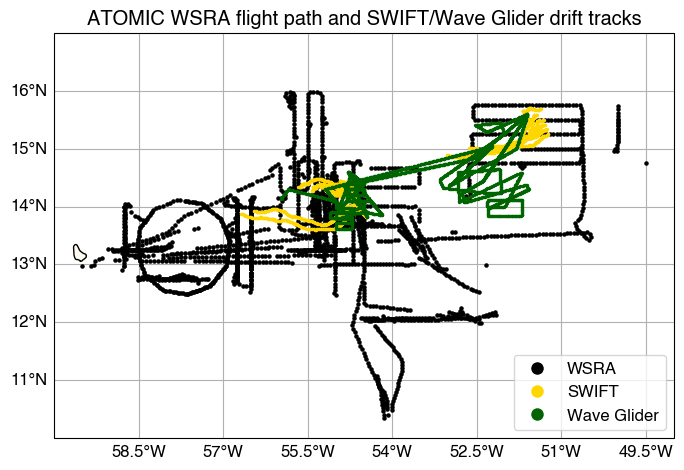

In [109]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=PROJECTION)

atomic_wsra.wsra.chart.ocean_color = 'white'  #'aliceblue' # 'whitesmoke'  # np.array([202, 210, 213])/255
atomic_wsra.wsra.chart.land_color = 'floralwhite'  # white

atomic_wsra.wsra.plot(
    plot_best_track=False,
    extent=(-60, -49, 10, 17),
    # column='ymd',
    # cmap='copper',
    # legend=True,
    ax=ax,
    # legend_kwds={
    # }
    label='WSRA'
)

for swift_id, swift_ds in atomic_swifts.items():
    ax.scatter(
        swift_ds['lon'],
        swift_ds['lat'],
        # c=swift_ds['ymd'].values,
        color='gold',
        s=2,
        label='SWIFT'
    )

for wave_glider_id, wave_glider_ds in atomic_wave_gliders.items():
    ax.scatter(
        wave_glider_ds['lon'],
        wave_glider_ds['lat'],
        s=2,
        color='darkgreen',
        label='Wave glider'
    )


# swift_ds.plot.scatter(x="lon", y="lat", hue="time")
legend_elements = [Line2D([0], [0], marker='o', color='w', label='WSRA',
                        markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='SWIFT',
                        markerfacecolor='gold', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Wave Glider',
                        markerfacecolor='darkgreen', markersize=10)]

ax.legend(handles=legend_elements, loc='lower right')
ax.set_title('ATOMIC WSRA flight path and SWIFT/Wave Glider drift tracks')


fig.savefig(f'ATOMIC_flight_and_drift_tracks.{IMAGE_FILE_TYPE}',
            format=IMAGE_FILE_TYPE,
            dpi=IMAGE_RESOLUTION)

#### WSRA flight metadata
Plot the WSRA flight metadata, including altitude, roll, and ground speed.

<GeoAxes: >

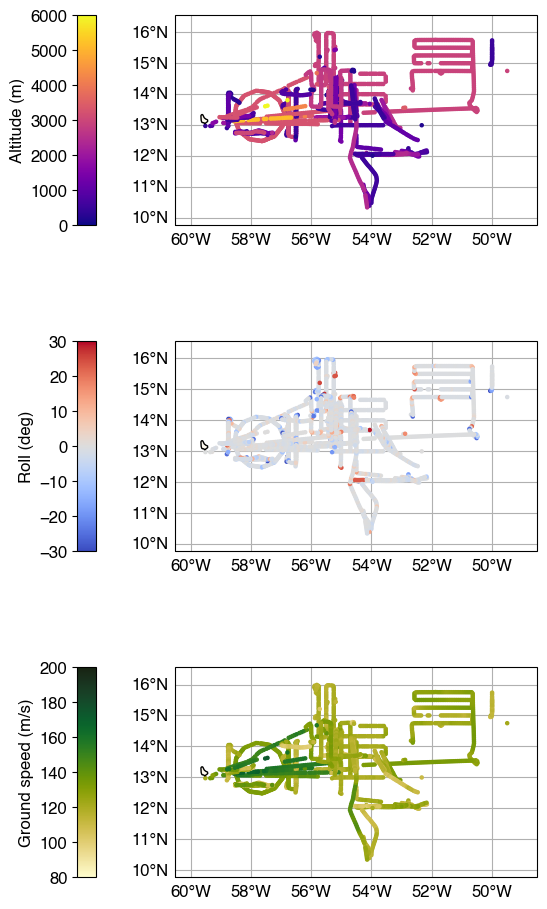

In [110]:
fig = plt.figure(figsize=(6, 12))
PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 600

# Plot altitude
ax = fig.add_subplot(3, 1, 1, projection=PROJECTION)
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes)
cmap = mpl.cm.plasma  # cmocean.cm.deep_r
norm = mpl.colors.Normalize(vmin=0, vmax=6000)
atomic_wsra.wsra.plot(
    column='platform_radar_altitude',  # 'ymd'
    plot_best_track=False,
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax,
    cax=cax,
    legend_kwds={
        "label": "Altitude (m)",
        "orientation": "vertical",
        "location": "left",
    }
)

# Plot roll
ax = fig.add_subplot(3, 1, 2, projection=PROJECTION)
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes)
cmap = mpl.cm.coolwarm
norm = mpl.colors.CenteredNorm(halfrange=30)
atomic_wsra.wsra.plot(
    column='wsra_computed_roll',  # 'ymd'
    plot_best_track=False,
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax,
    cax=cax,
    legend_kwds={
        "label": "Roll (deg)",
        "orientation": "vertical",
        "location": "left",
    }
)

# Plot ground speed
ax = fig.add_subplot(3, 1, 3, projection=PROJECTION)
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes)
cmap = cmocean.cm.speed
norm = mpl.colors.Normalize(vmin=80, vmax=200)
atomic_wsra.wsra.plot(
    column='platform_speed_wrt_ground',  # 'ymd'
    plot_best_track=False,
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax,
    cax=cax,
    legend_kwds={
        "label": "Ground speed (m/s)",
        "orientation": "vertical",
        "location": "left",
    }
)


# fig.savefig(f'WSRA_flight_parameters.{IMAGE_FILE_TYPE}',
#             format=IMAGE_FILE_TYPE,
#             dpi=IMAGE_RESOLUTION)

#### Masking
Create a trajectory mask. Use the limits specified in Pincus et al. (2021).

In [111]:
atomic_wsra.wsra.create_trajectory_mask(altitude_limits=(500, 4000),
                                        roll_limit=3)

Re-plot the (masked) trajectory.

Best track unavailable.


Text(0.5, 1.0, 'ATOMIC WSRA flight path (masked)')

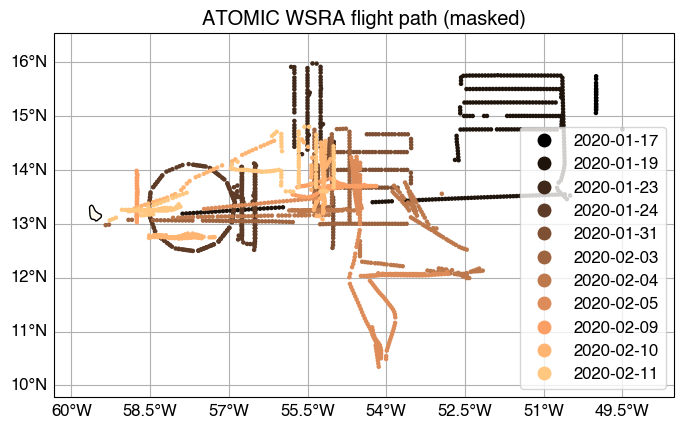

In [112]:
fig = plt.figure(figsize=(8, 6))
PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 300
ax = fig.add_subplot(1, 1, 1, projection=PROJECTION)

atomic_wsra_masked = atomic_wsra.wsra.mask()

atomic_wsra_masked.wsra.chart.ocean_color = 'white'  #'aliceblue' # 'whitesmoke'  # np.array([202, 210, 213])/255
atomic_wsra_masked.wsra.chart.land_color = 'floralwhite'  # white

atomic_wsra_masked.wsra.plot(
    column='ymd',
    cmap='copper',
    legend=True,
    ax=ax,
    legend_kwds={
    }
)
ax.set_title('ATOMIC WSRA flight path (masked)')

# fig.savefig(f'WSRA_flight_path_masked.{IMAGE_FILE_TYPE}',
#             format=IMAGE_FILE_TYPE,
#             dpi=IMAGE_RESOLUTION)


### Buoy colocation

In [113]:
#TODO: write code for colocating with a point source (buoy)

# see colocation -> colocate with grid

In [114]:
def great_circle_distance_pairwise(
    longitude_a: np.array,
    latitude_a: np.array,
    longitude_b: np.array,
    latitude_b: np.array,
    earth_radius: float = 6378.137,
    mod_bearing: bool = True
) -> Tuple:
    """
    Computes the great circle distance (km) and true fore bearing (deg) between
    pairs of observations in input arrays `longitude_a` and `longitude_b` and
    `latitude_a` and `latitude_b`.

    For two longitude and latitude pairs, the great circle distance is the
    shortest distance between the two points along the Earth's surface. This
    distance is calculated using the Haversine formula. The instances in
    `longitude_a` and `latitude_a` are designated as point `a`; the instances
    in `longitude_b` and `latitude_b` then form point `b`. The true fore
    bearing is the bearing, measured from true north, of `b` as seen from `a`.

    Note:
        When given `latitude_a/b` and `longitude_a/b` of shape (n,), n > 1,
        the great circle distance and fore bearing will be calculated between
        `a` and `b` entries such that the returned arrays will be of shape
        (n,). To compute the great circle distance and bearings between
        adjacent coordinates of single longitude and latitude arrays (i.e.,
        along a trajectory), use `haversine_distance`.

    Args:
        longitude_a (np.array): of shape (n,) in units of decimal degrees
        latitude (np.array): of shape (n,) in units of decimal degrees
        earth_radius (float, optional): earth's radius in units of km. Defaults to 6378.137 km (WGS-84)
        mod_bearing (bool, optional): return bearings modulo 360 deg. Defaults to True.

    Returns:
        Tuple[np.array, np.array]: great circle distances (in km) and true fore
        bearings between adjacent longitude and latitude pairs; shape (n,)

    Example: A trajectory along the Earth's equator.
    ```
    >> #TODO:
    ```
    """

    # convert decimal degrees to radians
    # longitude_a, latitude_a, longitude_b, latitude_b = map(np.radians, [longitude_a, latitude_a, longitude_b, latitude_b])

    longitude_a_rad, latitude_a_rad = map(np.radians, [longitude_a, latitude_a])
    longitude_b_rad, latitude_b_rad = map(np.radians, [longitude_b, latitude_b])

    # haversine formula
    dlon = longitude_b_rad - longitude_a_rad
    dlat = latitude_b_rad - latitude_a_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(latitude_a_rad) * np.cos(latitude_b_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    distance_km = earth_radius * c

    # bearing
    S = np.cos(latitude_b_rad)*np.sin(-dlon)
    C = np.cos(latitude_a_rad)*np.sin(latitude_b_rad) - np.sin(latitude_a_rad)*np.cos(latitude_b_rad)*np.cos(dlon)
    bearing_deg = (-np.degrees(np.arctan2(S, C)))
    if mod_bearing:
        bearing_deg = bearing_deg % 360


    # validation from R. Bullock: dist,bearing = haversine_distance(105.2833,40.0167,-137.65,-33.9333)
    return distance_km, bearing_deg


In [115]:
def colocate_with_path(
    wsra_ds: xr.Dataset,
    path_ds: xr.Dataset,
    path_vars: Tuple,
    wsra_vars: Tuple = ('time', 'latitude', 'longitude'),
    temporal_tolerance: np.timedelta64 = np.timedelta64(30, 'm'),
    spatial_tolerance: float = 1,  # km
) -> np.ndarray:
    """
    TODO: update!
    Match WSRA observations with gridded data (e.g., a model) using
    linear interpolation in time and bilinear interpolation in space.

    Note:
        `path_vars` and `wsra_vars` are tuples specifying the names of the
        coordinates and fields to interpolate. The names must be ordered as:
        time, latitude, longitude, and field where field is the variable in
        `path_ds` to be in colocated onto the WSRA dataset (and thus is only
        provided only for `path_vars`).

        For instance, if the gridded dataset coordinates are labeled as 'time',
        'lat', and 'lon' and 'wind_speed' is the field to be colocated onto the
        WSRA dataset, `path_vars` should be:
        >>> path_vars = ('time', 'lat', 'lon', 'wind_speed)

        `wsra_vars` defaults to the standard dataset names, though these should
        be provided if the defaults have been modified.

        Out-of-bound points are replaced by NaNs.

    Args:
        wsra_ds (xr.Dataset): WSRA observations
        path_ds (xr.Dataset): gridded data with a field variable to be
            interpolated onto the WSRA observations
        temporal_tolerance (np.timedelta64, optional): max allowable time delta
            between model and grid times. Defaults to np.timedelta64(30, 'm').

    Returns:
        np.ndarray: field variable values interpolated onto the WSRA time and
            spatial coordinates.
    TODO: update!

    """

    wsra_time = wsra_ds[wsra_vars[0]].values
    wsra_latitude = wsra_ds[wsra_vars[1]].values
    wsra_longitude = wsra_ds[wsra_vars[2]].values

    path_time = path_ds[path_vars[0]].values
    path_latitude = path_ds[path_vars[1]].values
    path_longitude = path_ds[path_vars[2]].values
    # path_field = path_ds[path_vars[3]].values

    t_sort_indices = np.searchsorted(path_time, wsra_time)

    t_sort_indices[t_sort_indices >= len(path_time)] = len(path_time)-1

    time_difference = np.abs(wsra_time - path_time[t_sort_indices])

    in_time = time_difference < temporal_tolerance

    # t_sort_indices_ma = t_sort_indices[in_time]

    distances, bearings = great_circle_distance_pairwise(
        longitude_a=wsra_longitude,
        latitude_a=wsra_latitude,
        longitude_b=path_longitude[t_sort_indices],
        latitude_b=path_latitude[t_sort_indices]
    )

    in_range = distances < spatial_tolerance

    matching_boolean = np.logical_and(in_time, in_range)


    matching_wsra_indices = np.where(matching_boolean)[0]
    matching_path_indices = t_sort_indices[matching_boolean]


    return matching_wsra_indices, matching_path_indices

Plot co-located mean square slopes

In [116]:
for swift_id in atomic_swifts.keys():  # ['SWIFT23']:  #atomic_swifts.keys():

    matching_wsra_indices, matching_path_indices = colocate_with_path(
        wsra_ds = atomic_wsra.wsra.mask(),
        path_ds = atomic_swifts[swift_id],
        path_vars = ('time', 'lat', 'lon', 'sea_surface_wave_mean_square_slope_normalized_by_frequency_width'),
        wsra_vars = ('time', 'latitude', 'longitude'),
        temporal_tolerance = np.timedelta64(60, 'm'),
        spatial_tolerance = 55,  #km
    )

    wsra_ds_matches = atomic_wsra.isel(trajectory=matching_wsra_indices)
    swift_ds_matches = atomic_swifts[swift_id].isel(time=matching_path_indices)


Text(0, 0.5, 'SWIFT mean square slope')

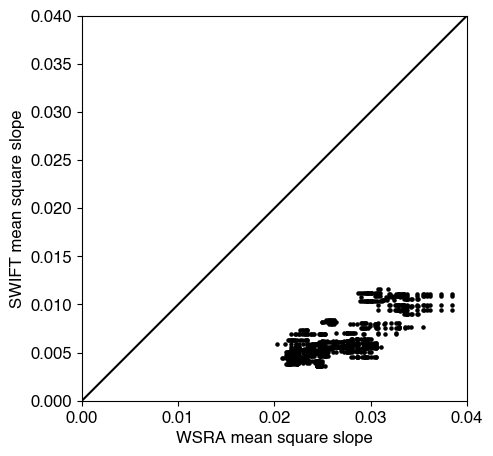

In [117]:
fig, ax = plt.subplots(figsize=(6, 5))
IMAGE_RESOLUTION = 400
limits = [0, 0.04]

for swift_id in atomic_swifts.keys():  # ['SWIFT23']:  #atomic_swifts.keys():

    matching_wsra_indices, matching_path_indices = colocate_with_path(
        wsra_ds = atomic_wsra.wsra.mask(),
        path_ds = atomic_swifts[swift_id],
        path_vars = ('time', 'lat', 'lon', 'sea_surface_wave_mean_square_slope_normalized_by_frequency_width'),
        wsra_vars = ('time', 'latitude', 'longitude'),
        temporal_tolerance = np.timedelta64(60, 'm'),
        spatial_tolerance = 55,  #km
    )

    wsra_ds_matches = atomic_wsra.isel(trajectory=matching_wsra_indices)
    swift_ds_matches = atomic_swifts[swift_id].isel(time=matching_path_indices)

    ax.scatter(
        wsra_ds_matches['sea_surface_mean_square_slope_median'],
        swift_ds_matches['mean_square_slope'],
        color='k',
        s=5,
    )

ax.set_aspect('equal')
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.plot(limits, limits, color='k')
ax.set_xlabel('WSRA mean square slope')
ax.set_ylabel('SWIFT mean square slope')
# fig.savefig(f'WSRA_and_SWIFT_mean_square_slope.{IMAGE_FILE_TYPE}',
#             format=IMAGE_FILE_TYPE,
#             dpi=IMAGE_RESOLUTION)

Text(0.5, 0, 'wind speed (m/s) [NOT SAME REFERENCE]')

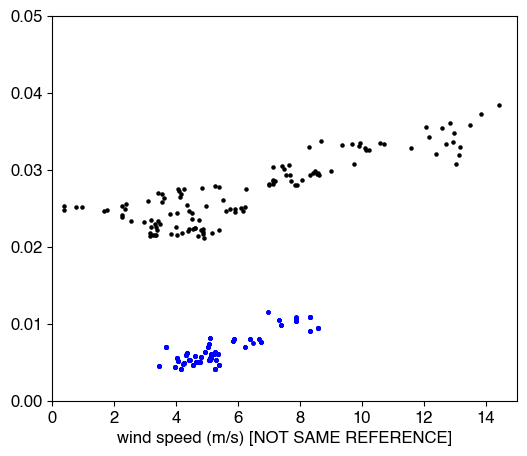

In [118]:
fig, ax = plt.subplots(figsize=(6, 5))
IMAGE_RESOLUTION = 400
limits = [0, 0.04]

ax.scatter(
    wsra_ds_matches['wind_speed'],
    wsra_ds_matches['sea_surface_mean_square_slope_median'],
    color='k',
    s=5,
)


for swift_id in atomic_swifts.keys():  # ['SWIFT23']:  #atomic_swifts.keys():

    matching_wsra_indices, matching_path_indices = colocate_with_path(
        wsra_ds = atomic_wsra.wsra.mask(),
        path_ds = atomic_swifts[swift_id],
        path_vars = ('time', 'lat', 'lon', 'sea_surface_wave_mean_square_slope_normalized_by_frequency_width'),
        wsra_vars = ('time', 'latitude', 'longitude'),
        temporal_tolerance = np.timedelta64(60, 'm'),
        spatial_tolerance = 55,  #km
    )

    wsra_ds_matches = atomic_wsra.isel(trajectory=matching_wsra_indices)
    swift_ds_matches = atomic_swifts[swift_id].isel(time=matching_path_indices)

    ax.scatter(
        swift_ds_matches['wind_speed'],
        swift_ds_matches['mean_square_slope'],
        color='b',
        s=5,
    )


ax.set_ylim(0, 0.05)
ax.set_xlim(0, 15)
ax.set_xlabel('wind speed (m/s) [NOT SAME REFERENCE]')

Co-locate all observations and save the indices in a dictionary

In [119]:
matching_wsra_indices = {}
matching_swift_indices = {}

for swift_id in atomic_swifts.keys():  # ['SWIFT23']:  #atomic_swifts.keys():

        wsra_indices, swift_indices = colocate_with_path(
            wsra_ds = atomic_wsra.wsra.mask(),
            path_ds = atomic_swifts[swift_id],
            path_vars = ('time', 'lat', 'lon', ''),
            wsra_vars = ('time', 'latitude', 'longitude'),
            temporal_tolerance = np.timedelta64(60, 'm'),
            spatial_tolerance = 55,  #km
        )

        matching_wsra_indices[swift_id] = wsra_indices
        matching_swift_indices[swift_id] = swift_indices

### Comparisons

#### Significant wave height comparison

Plot significant wave height

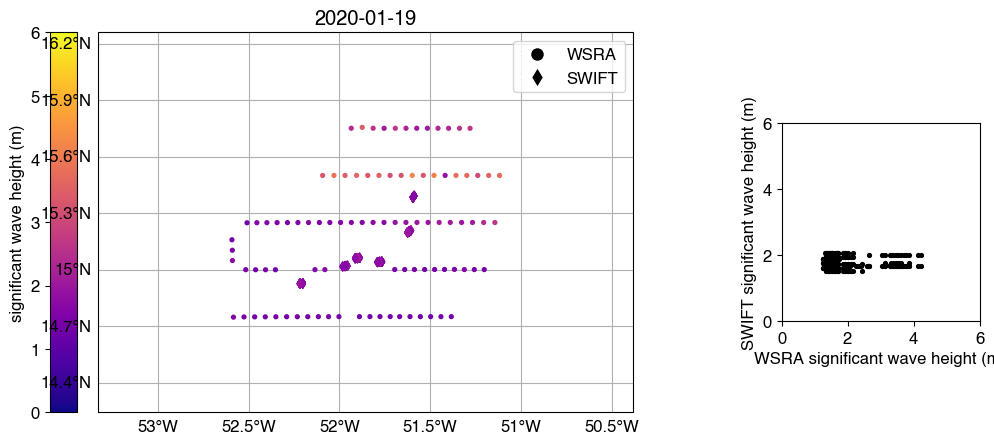

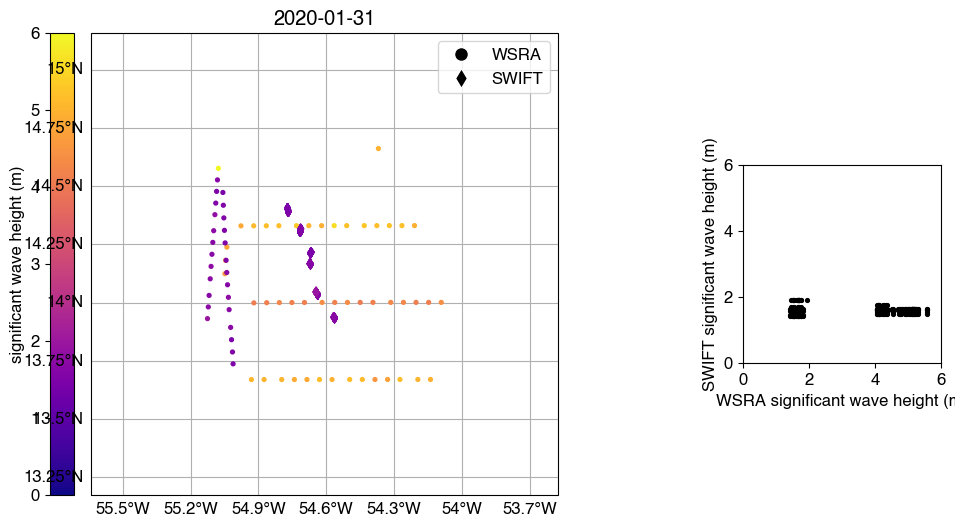

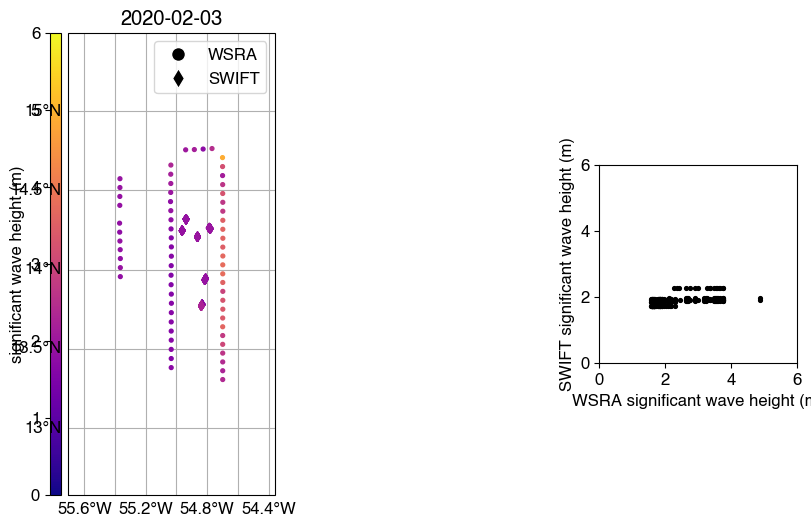

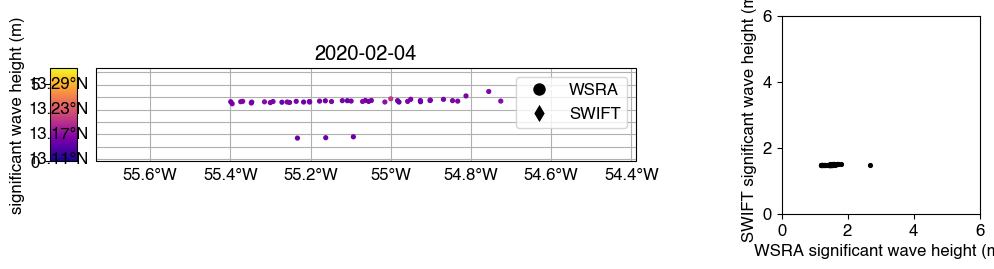

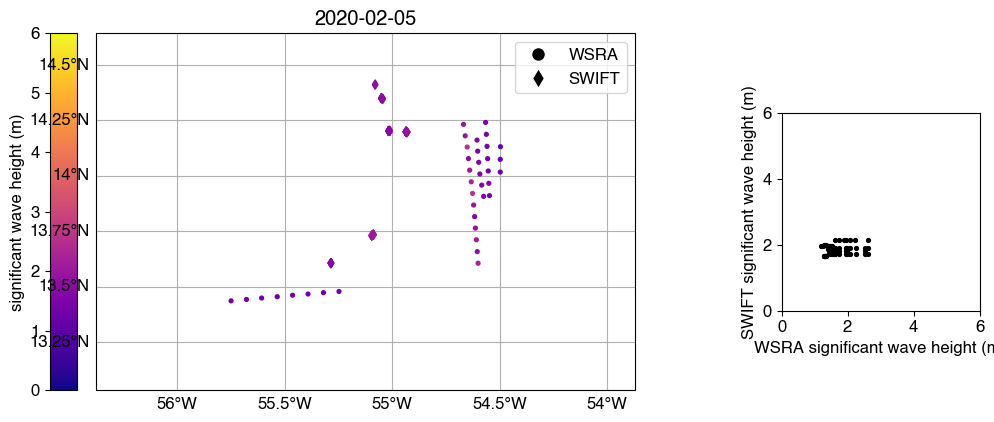

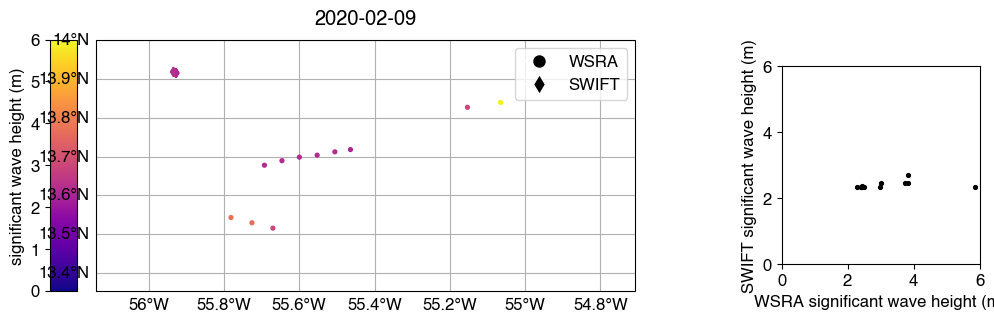

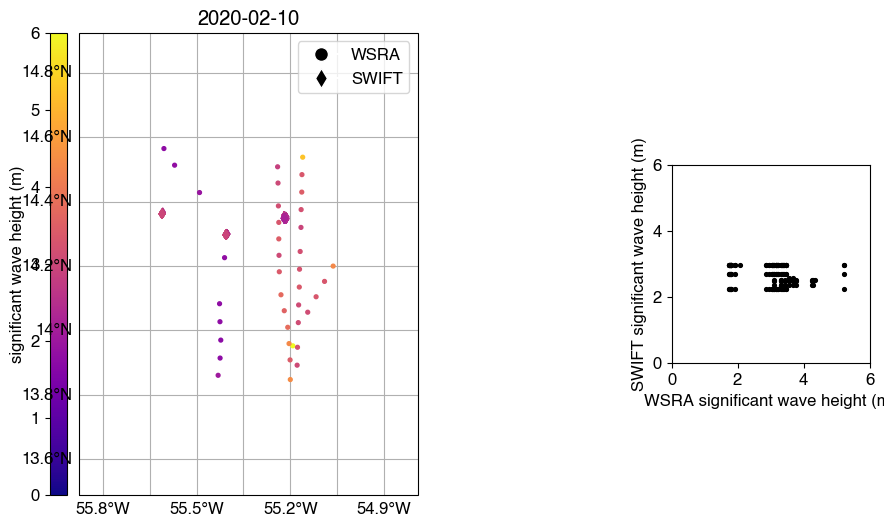

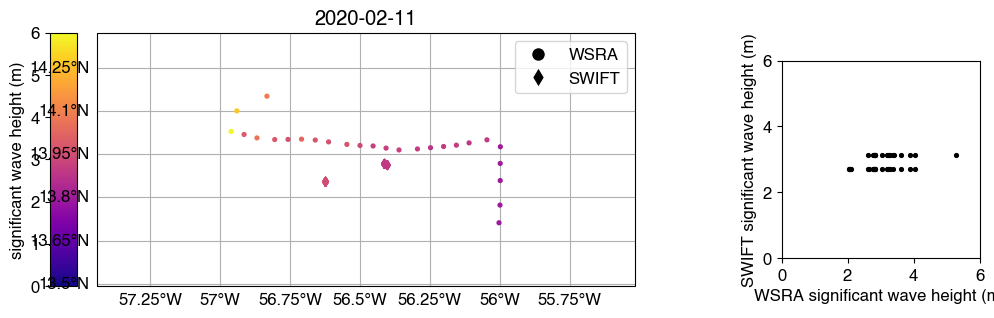

In [120]:
#TODO: test a plot with ALL buoys on the same figure (no ymd) and compare to above
#TODO: is it right to plot all on the same figures? Really we need it by the hour

wsra_var='sea_surface_wave_significant_height'
swift_var='sea_surface_wave_significant_height'
cmap=mpl.cm.plasma
norm=mpl.colors.Normalize(vmin=0, vmax=6)

unique_matching_wsra_indices = np.unique(np.hstack(list(matching_wsra_indices.values())))
wsra_ds_matches = atomic_wsra.isel(trajectory=unique_matching_wsra_indices)

mission_dates = np.unique(wsra_ds_matches['ymd'])

for ymd in mission_dates:

    fig = plt.figure(figsize=(12, 6))
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace = .35)
    ax1 = fig.add_subplot(gs[0], projection=PROJECTION)
    ax2 = fig.add_subplot(gs[1])

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes, pad="2%")


    wsra_ds_in_mission = wsra_ds_matches.where(wsra_ds_matches['ymd'] == ymd)

    wsra_ds_in_mission.wsra.chart.ocean_color = 'white' # 'whitesmoke'
    wsra_ds_in_mission.wsra.chart.land_color = 'floralwhite'  # white, whitesmoke
    wsra_ds_in_mission.wsra.chart.buffer_percent=.5


    wsra_ds_in_mission.wsra.plot(
        column=wsra_var,
        plot_best_track=False,
        legend=True,
        marker='.',
        markersize=30,
        label='WSRA',
        cmap=cmap,
        norm=norm,
        ax=ax1,
        cax=cax,
        legend_kwds={
            "orientation": "vertical",
            "location": "left",
        }
    )


    for swift_id in atomic_swifts.keys():  # ['SWIFT23']:  #atomic_swifts.keys():
        swift_ds = atomic_swifts[swift_id]
        swift_ds_matches = swift_ds.isel(time=matching_swift_indices[swift_id])
        swift_ds_in_mission = swift_ds_matches.where(swift_ds_matches['ymd'] == ymd)


        ax1.scatter(
            swift_ds_in_mission['lon'],
            swift_ds_in_mission['lat'],
            c=swift_ds_in_mission[swift_var],
            s=20,
            marker='d',
            label='SWIFT',
            cmap=cmap,
            norm=norm,
        )


        wsra_ds_matches_2 = atomic_wsra.isel(trajectory=matching_wsra_indices[swift_id])
        wsra_ds_in_mission_2 = wsra_ds_matches_2.where(wsra_ds_matches_2['ymd'] == ymd)

        ax2.scatter(
            wsra_ds_in_mission_2[wsra_var],
            swift_ds_in_mission[swift_var],
            color='k',
            s=7.5,
        )

    legend_elements = [Line2D([0], [0], marker='o', color='w', label='WSRA',
                            markerfacecolor='k', markersize=10),
                    Line2D([0], [0], marker='d', color='w', label='SWIFT',
                            markerfacecolor='k', markersize=10)]

    ax1.set_title(f'{ymd}')
    ax1.legend(handles=legend_elements) # loc='lower right'
    cax.set_ylabel('significant wave height (m)')
    ax2.set_xlabel('WSRA significant wave height (m)')
    ax2.set_ylabel('SWIFT significant wave height (m)')
    ax2.set_xlim([0, 6])
    ax2.set_ylim([0, 6])
    ax2.set_aspect('equal')

    # fig.savefig(f'WSRA_and_SWIFT_{ymd}_significant_wave_height.{IMAGE_FILE_TYPE}',
    #             format=IMAGE_FILE_TYPE,
    #             dpi=IMAGE_RESOLUTION)



#### Mean square slope comparison

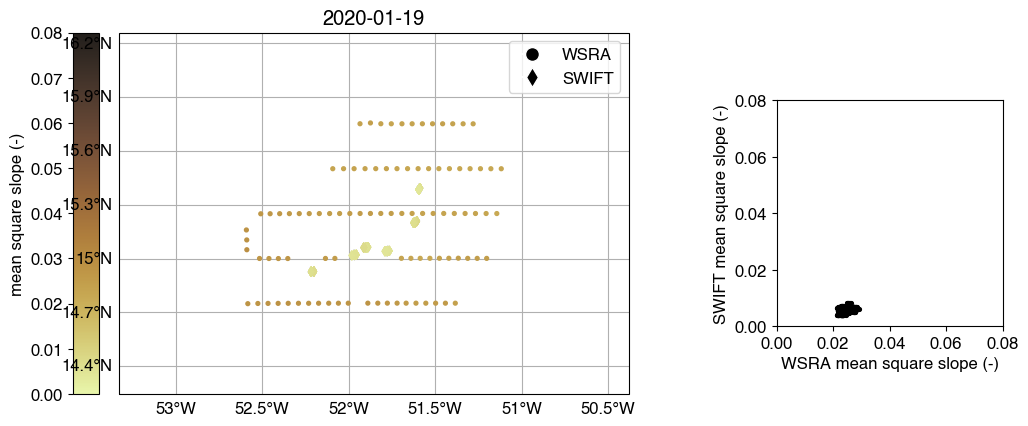

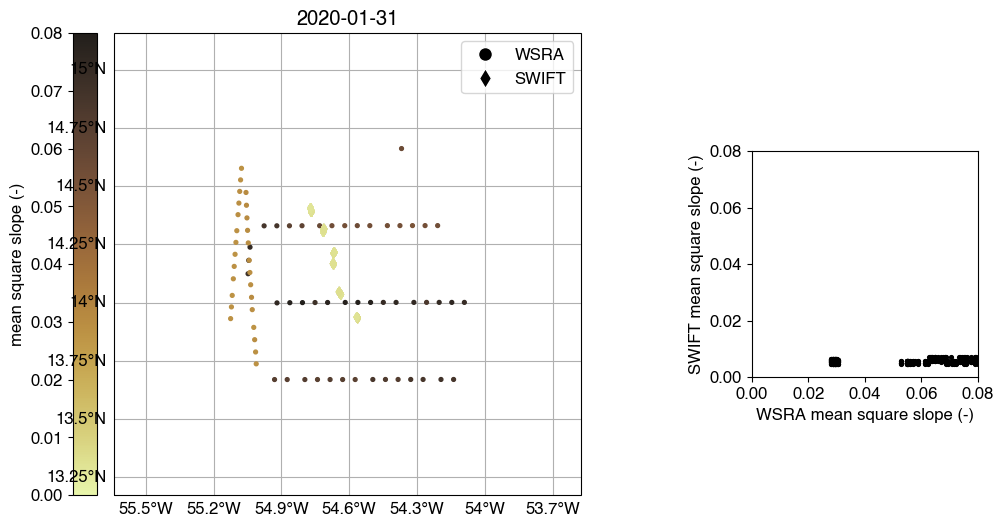

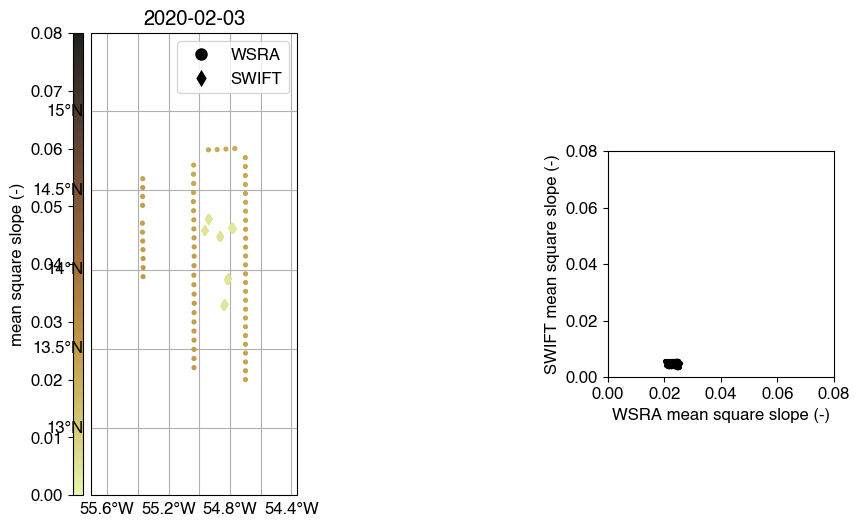

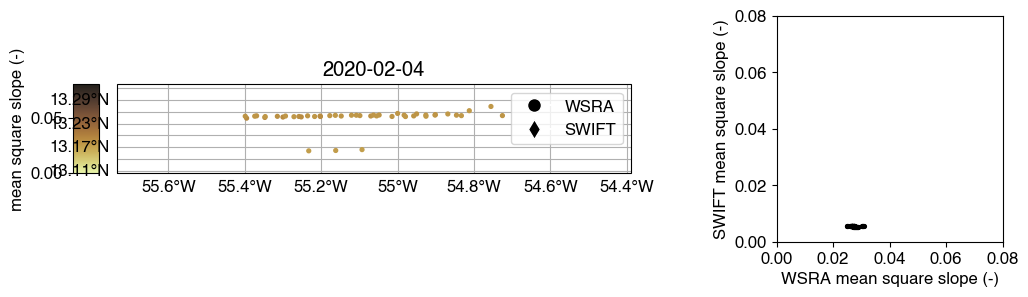

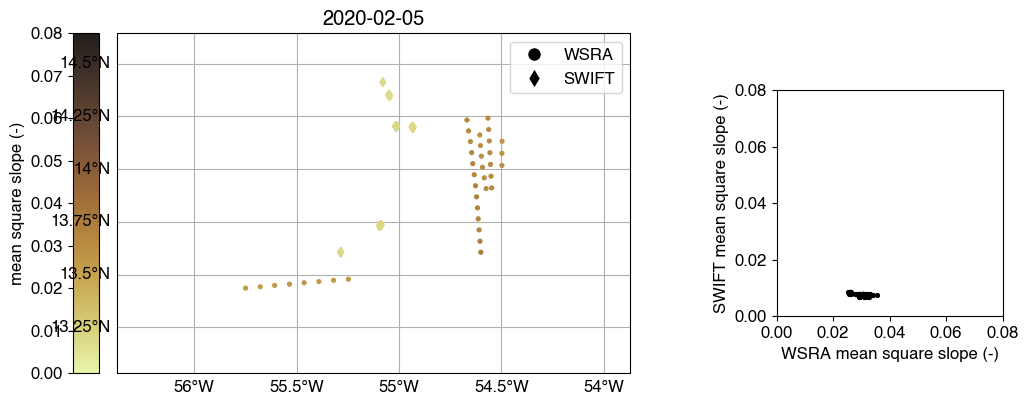

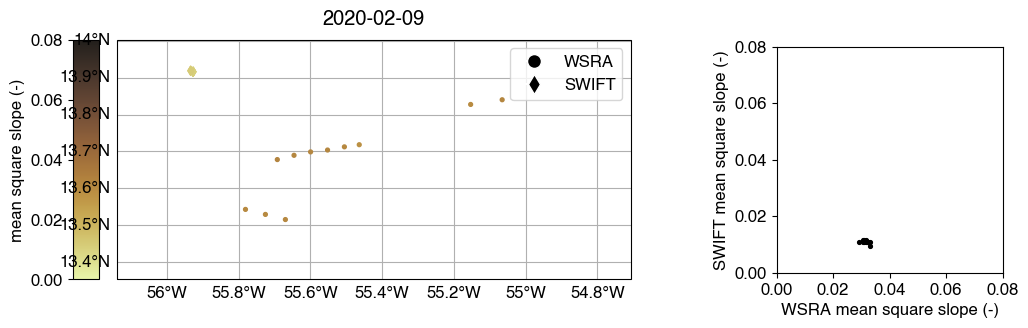

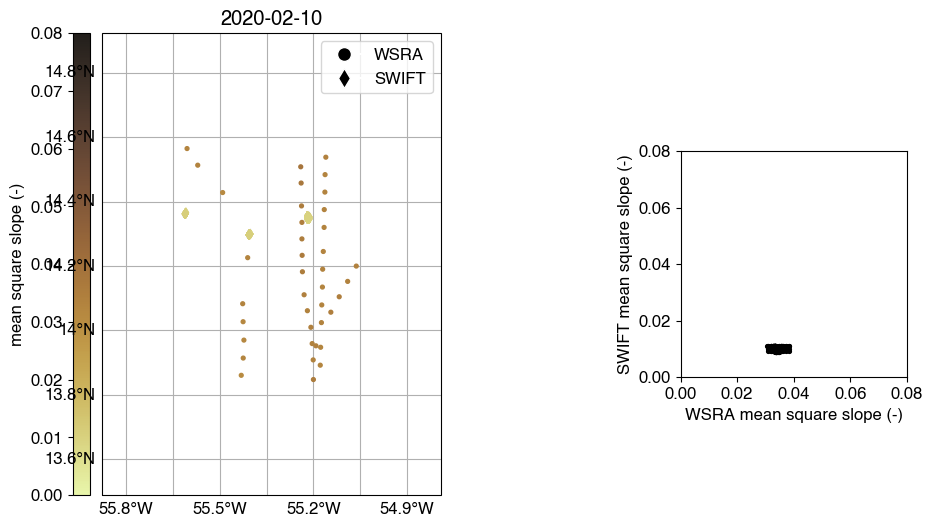

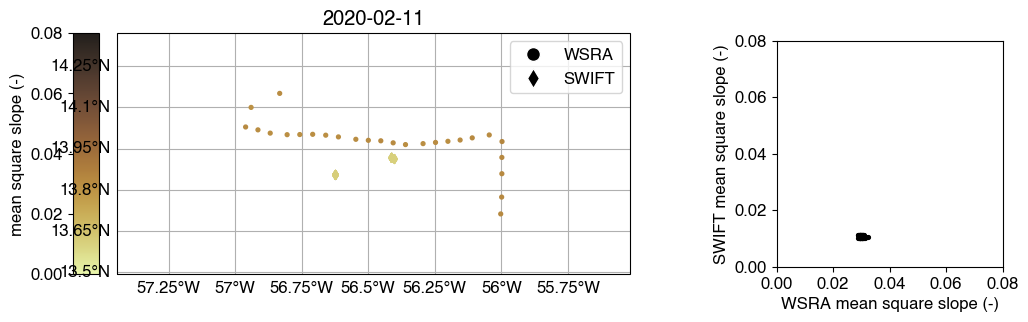

In [121]:
#TODO: test a plot with ALL buoys on the same figure (no ymd) and compare to above
#TODO: is it right to plot all on the same figures? Really we need it by the hour

wsra_var='sea_surface_mean_square_slope_median'
swift_var='mean_square_slope'
cmap=cmocean.cm.turbid
norm=mpl.colors.Normalize(vmin=0, vmax=0.08)

unique_matching_wsra_indices = np.unique(np.hstack(list(matching_wsra_indices.values())))
wsra_ds_matches = atomic_wsra.isel(trajectory=unique_matching_wsra_indices)

mission_dates = np.unique(wsra_ds_matches['ymd'])

for ymd in mission_dates:

    fig = plt.figure(figsize=(12, 6))
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace = .35)
    ax1 = fig.add_subplot(gs[0], projection=PROJECTION)
    ax2 = fig.add_subplot(gs[1])

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes, pad="2%")


    wsra_ds_in_mission = wsra_ds_matches.where(wsra_ds_matches['ymd'] == ymd)

    wsra_ds_in_mission.wsra.chart.ocean_color = 'white' # 'whitesmoke'
    wsra_ds_in_mission.wsra.chart.land_color = 'floralwhite'  # white, whitesmoke
    wsra_ds_in_mission.wsra.chart.buffer_percent=.5


    wsra_ds_in_mission.wsra.plot(
        column=wsra_var,
        plot_best_track=False,
        legend=True,
        marker='.',
        markersize=30,
        label='WSRA',
        cmap=cmap,
        norm=norm,
        ax=ax1,
        cax=cax,
        legend_kwds={
            "orientation": "vertical",
            "location": "left",
        }
    )


    for swift_id in atomic_swifts.keys():  # ['SWIFT23']:  #atomic_swifts.keys():
        swift_ds = atomic_swifts[swift_id]
        swift_ds_matches = swift_ds.isel(time=matching_swift_indices[swift_id])
        swift_ds_in_mission = swift_ds_matches.where(swift_ds_matches['ymd'] == ymd)


        ax1.scatter(
            swift_ds_in_mission['lon'],
            swift_ds_in_mission['lat'],
            c=swift_ds_in_mission[swift_var],
            s=20,
            marker='d',
            label='SWIFT',
            cmap=cmap,
            norm=norm,
        )


        wsra_ds_matches_2 = atomic_wsra.isel(trajectory=matching_wsra_indices[swift_id])
        wsra_ds_in_mission_2 = wsra_ds_matches_2.where(wsra_ds_matches_2['ymd'] == ymd)

        ax2.scatter(
            wsra_ds_in_mission_2[wsra_var],
            swift_ds_in_mission[swift_var],
            color='k',
            s=7.5,
        )

    legend_elements = [Line2D([0], [0], marker='o', color='w', label='WSRA',
                            markerfacecolor='k', markersize=10),
                    Line2D([0], [0], marker='d', color='w', label='SWIFT',
                            markerfacecolor='k', markersize=10)]

    ax1.set_title(f'{ymd}')
    ax1.legend(handles=legend_elements) # loc='lower right'
    cax.set_ylabel('mean square slope (-)')
    ax2.set_xlabel('WSRA mean square slope (-)')
    ax2.set_ylabel('SWIFT mean square slope (-)')
    ax2.set_xlim([0, 0.08])
    ax2.set_ylim([0, 0.08])
    ax2.set_aspect('equal')



    # fig.savefig(f'WSRA_and_SWIFT_{ymd}_mean_square_slope.{IMAGE_FILE_TYPE}',
    #             format=IMAGE_FILE_TYPE,
    #             dpi=IMAGE_RESOLUTION)



#### Wave direction comparison

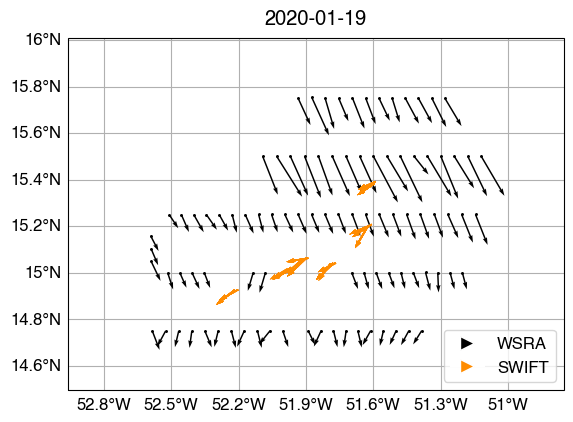

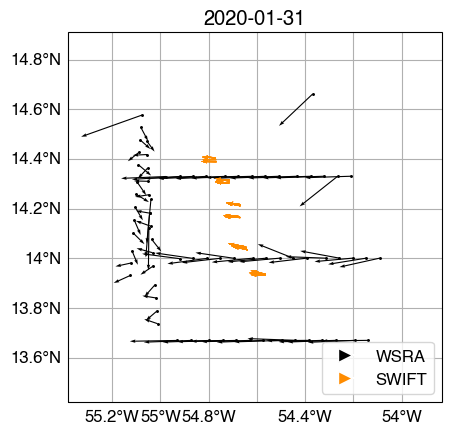

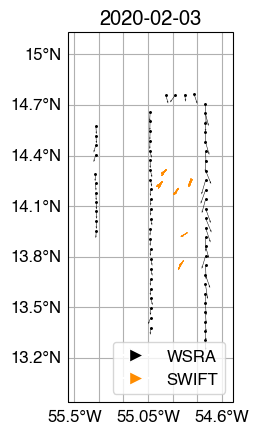

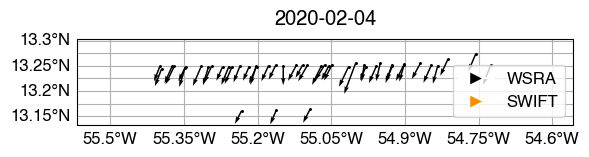

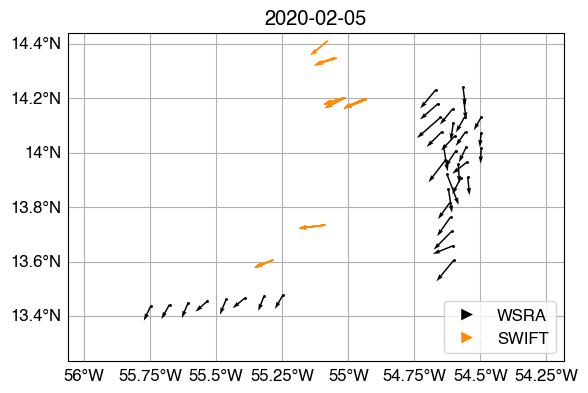

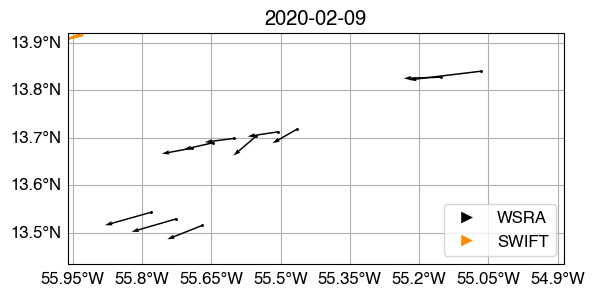

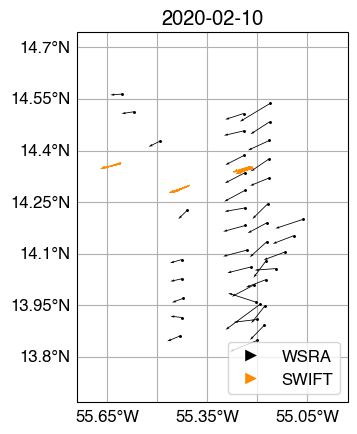

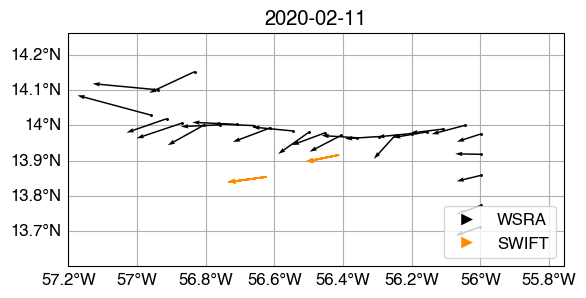

In [122]:
unique_matching_wsra_indices = np.unique(np.hstack(list(matching_wsra_indices.values())))
wsra_ds_matches = atomic_wsra.isel(trajectory=unique_matching_wsra_indices)

mission_dates = np.unique(wsra_ds_matches['ymd'])

for ymd in mission_dates:

    fig = plt.figure()  #(figsize=(6, 6))
    PROJECTION = cartopy.crs.PlateCarree()
    ax1 = fig.add_subplot(111, projection=PROJECTION)

    wsra_ds_in_mission = wsra_ds_matches.where(wsra_ds_matches['ymd'] == ymd)

    wsra_ds_in_mission.wsra.chart.ocean_color='white'
    wsra_ds_in_mission.wsra.chart.buffer_percent=.25


    wsra_ds_in_mission.wsra.plot(
        marker='.',
        ax=ax1,
        plot_best_track=False,
    )

    ax1.quiver(
        wsra_ds_in_mission['longitude'],
        wsra_ds_in_mission['latitude'],
        wsra_ds_in_mission['wave_u'],
        wsra_ds_in_mission['wave_v'],
        scale=40,
        color='black',
        width=0.003,
    )

    for swift_id in atomic_swifts.keys():  # ['SWIFT23']:  #atomic_swifts.keys():
        swift_ds = atomic_swifts[swift_id]
        swift_ds_matches = swift_ds.isel(time=matching_swift_indices[swift_id])
        swift_ds_in_mission = swift_ds_matches.where(swift_ds_matches['ymd'] == ymd)


        ax1.quiver(
            swift_ds_in_mission['lon'],
            swift_ds_in_mission['lat'],
            swift_ds_in_mission['wave_u'],
            swift_ds_in_mission['wave_v'],
            scale=40,
            color='darkorange',
            width=0.003,
        )

    ax1.set_title(f'{ymd}')

    # swift_ds.plot.scatter(x="lon", y="lat", hue="time")
    legend_elements = [Line2D([0], [0], marker='>', color='w', label='WSRA',
                            markerfacecolor='k', markersize=10),
                    Line2D([0], [0], marker='>', color='w', label='SWIFT',
                            markerfacecolor='darkorange', markersize=10)]

    ax1.legend(handles=legend_elements, loc='lower right')

    # fig.savefig(f'WSRA_and_SWIFT_{ymd}_wave_direction.{IMAGE_FILE_TYPE}',
    #             format=IMAGE_FILE_TYPE,
    #             dpi=IMAGE_RESOLUTION)


#### Directional spectra comparison

In [123]:
#TODO: make comparison plots with SWIFT from bigwaves

In [124]:
def plot_wsra_spectrum(
    energy,
    wave_number_east,
    wave_number_north,
    ax,
    normalize = False,
    density = True,
):
    if density:
        mean_area = np.outer(np.diff(wave_number_east.values),
                            np.diff(wave_number_north.values)).mean()  # rad^2/m^2
        energy_plot = energy / mean_area  # m^4/rad^2
        cbar_label = 'energy density ($\mathrm{m^4 / rad^2}$)'
    else:
        energy_plot = energy.copy()  # m^2
        cbar_label = 'energy ($\mathrm{m^2}$)'

    if normalize:
        energy_plot = energy / energy.max()
        cbar_label = 'normalized energy (-)'

    cmap = cmocean.cm.amp
    cmap.set_under('white')

    pcm = ax.pcolormesh(
        wave_number_east,
        wave_number_north,
        energy_plot,
        cmap=cmap,  #'magma',
        # vmin=0.1,
        shading='gouraud',
    )
    ax.set_aspect('equal')
    ax.spines['left'].set_position(('data', 0.0))
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines.bottom.set_bounds(ticks.min(), ticks.max())
    # ax.spines.left.set_bounds(ticks.min(), ticks.max())

    ticks = np.linspace(-0.08, 0.08, 9)
    ticks = ticks[np.abs(ticks) > 0]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlim([ticks.min(), ticks.max()])
    ax.set_ylim([ticks.min(), ticks.max()])

    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)

    #TODO: could be clever and use the region opposite of the psv

    # ax.set_xlabel('east wavenumber (rad/m)', ha='right', va='top', rotation='horizontal')
    # ax.xaxis.set_label_coords(1, 0)
    ax.set_xlabel('east wavenumber (rad/m)', ha='right', va='bottom', rotation=0, fontsize=9)
    ax.xaxis.set_label_coords(1.0, 0.5)  # (1, 0)

    # ax.set_ylabel('north wavenumber (rad/m)', ha='right', va='bottom', rotation=180)
    # ax.yaxis.set_label_coords(0, 1)
    ax.set_ylabel('north wavenumber (rad/m)', ha='right', va='top', rotation=90, fontsize=9)
    ax.yaxis.set_label_coords(0.505, 1.0)

    circle_radians = np.deg2rad(np.linspace(0, 360, 100))
    circle_x = np.sin(circle_radians)
    circle_y = np.cos(circle_radians)
    circle_wavenumbers = np.array([0.02, 0.04, 0.06, 0.08])
    circles_xx = np.outer(circle_x, circle_wavenumbers)
    circles_yy = np.outer(circle_y, circle_wavenumbers)
    circles = ax.plot(
        circles_xx,
        circles_yy,
        color='k',
        alpha=0.25,
        linewidth=1,
        linestyle=':',
    )

    spoke_angles = np.array([45, 135 ])
    spoke_angles = np.deg2rad(np.linspace(0, 360, 17))

    spoke_x = 0.08 * np.sin(spoke_angles)[None, :]
    spoke_y = 0.08 * np.cos(spoke_angles)[None, :]

    spoke_x_line = np.vstack([np.zeros(spoke_x.shape), spoke_x])
    spoke_y_line = np.vstack([np.zeros(spoke_y.shape), spoke_y])

    spokes = ax.plot(
        spoke_x_line, spoke_y_line,
        color='k',
        alpha=0.25,
        linewidth=1,
        linestyle='-',
    )


    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad="5%", axes_class=mpl.axes.Axes)
    cbar = plt.colorbar(pcm, cax=cax)
    cbar.set_label(cbar_label)

    #  Border
    # ax.patch.set_edgecolor('black')
    # ax.patch.set_linewidth(1)

In [125]:
# ymd =  '2020-01-19'  #'2020-01-19'
ymd =  '2020-02-10'  #'2020-01-19'
wsra_in_mission = wsra_ds_matches.where(wsra_ds_matches['ymd'] == ymd)
wsra_in_mission['time'][~np.isnan(wsra_in_mission['time'])]

<xarray.DataArray 'time' (trajectory: 39)>
array(['2020-02-10T07:23:26.000000000', '2020-02-10T07:24:16.000000000',
       '2020-02-10T07:25:06.000000000', '2020-02-10T07:25:56.000000000',
       '2020-02-10T07:27:40.000000000', '2020-02-10T07:29:20.000000000',
       '2020-02-10T07:56:37.000000000', '2020-02-10T07:57:27.000000000',
       '2020-02-10T07:58:17.000000000', '2020-02-10T07:59:07.000000000',
       '2020-02-10T07:59:57.000000000', '2020-02-10T08:01:07.000000000',
       '2020-02-10T08:01:57.000000000', '2020-02-10T08:02:47.000000000',
       '2020-02-10T08:03:37.000000000', '2020-02-10T08:04:27.000000000',
       '2020-02-10T08:05:37.000000000', '2020-02-10T08:06:27.000000000',
       '2020-02-10T08:09:08.000000000', '2020-02-10T08:09:58.000000000',
       '2020-02-10T08:10:48.000000000', '2020-02-10T08:11:38.000000000',
       '2020-02-10T08:12:28.000000000', '2020-02-10T08:13:38.000000000',
       '2020-02-10T08:14:28.000000000', '2020-02-10T08:15:18.000000000',
       '2020-02-10T08:16:08.000000000', '2020-02-10T08:16:58.000000000',
       '2020-02-10T08:18:08.000000000', '2020-02-10T08:18:58.000000000',
       '2020-02-10T08:47:25.000000000', '2020-02-10T08:48:15.000000000',
       '2020-02-10T08:49:05.000000000', '2020-02-10T08:49:55.000000000',
       '2020-02-10T08:50:45.000000000', '2020-02-10T08:52:57.000000000',
       '2020-02-10T08:56:06.000000000', '2020-02-10T08:57:41.000000000',
       '2020-02-10T08:58:31.000000000'], dtype='datetime64[ns]')
Coordinates:
  * trajectory       (trajectory) int32 82 83 84 85 86 ... 165 166 167 168 169
    trajectory_mask  (trajectory) bool True True True True ... True True True
Attributes:
    axis:           T
    long_name:      Time of observation
    standard_name:  time

AttributeError: 'NoneType' object has no attribute 'pcolormesh'

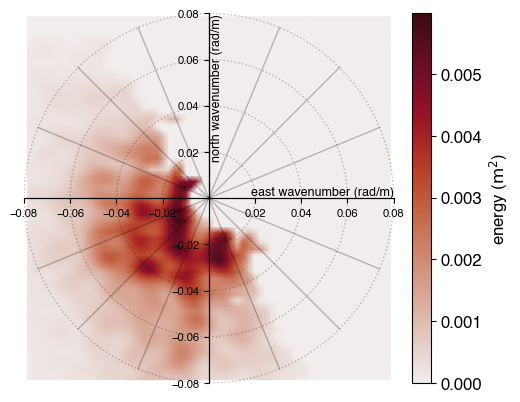

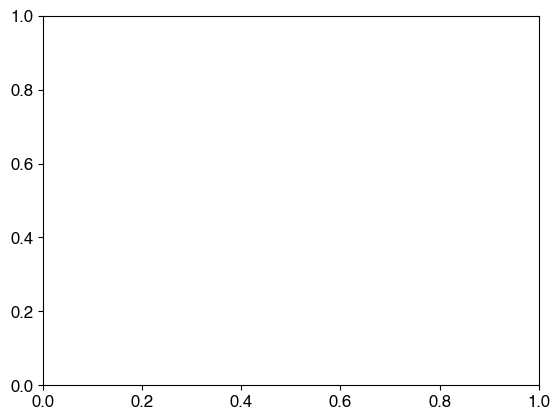

In [126]:
# ymd =  '2020-01-19'  #'2020-01-19'
# wsra_in_mission = wsra_ds_matches.where(wsra_ds_matches['ymd'] == ymd)

# start_date = datetime(2020, 1, 19, 16)
# end_date = datetime(2020, 1, 19, 18)
# start_date = datetime(2020, 2, 3, 16)
# end_date = datetime(2020, 2, 3, 18)
start_date = datetime(2020, 2, 10, 7, 0, 0)
end_date = datetime(2020, 2, 10, 9, 0, 0)

wsra_in_mission = wsra_ds_matches.assign_coords({'time': wsra_ds_matches.time})
wsra_in_mission = wsra_in_mission.set_xindex(['time'])
wsra_in_mission = wsra_in_mission.sel(time=slice(start_date, end_date))


wave_number_east = wsra_in_mission['wavenumber_east']
wave_number_north = wsra_in_mission['wavenumber_north']
energy = wsra_in_mission['directional_wave_spectrum'][4].T  #TODO: why is this transpose needed...?
average_energy = np.nanmean(wsra_in_mission['directional_wave_spectrum'][:], axis=0).T

fig, ax = plt.subplots()
plot_wsra_spectrum(energy, wave_number_east, wave_number_north, ax, density=False)

fig, ax = plt.subplots()
pywsra.plot_wavenumber_spectrum(average_energy, wave_number_east, wave_number_north, ax)
ax.set_title(f"WSRA {start_date.strftime('%Y-%m-%d %H00')}"
             f" to {end_date.strftime('%Y-%m-%d %H00')}")
fig.savefig(f"WSRA_spectrum_{start_date.strftime('%Y-%m-%d_%H00')}"
             f"_to_{end_date.strftime('%Y-%m-%d_%H00')}.png", dpi=400, format='png')

#### Scalar spectra comparison

Convert from WSRA 2-D wavenumber spectrum to the frequency-direction spectrum.

In [127]:
from scipy.optimize import newton

GRAVITY = 9.81

def intrinsic_dispersion_relation(wavenumber, depth=np.inf):
    GRAVITY = 9.81
    gk = GRAVITY * wavenumber
    kh = wavenumber * depth
    return np.sqrt(gk * np.tanh(kh))  # angular frequency

def phase_velocity(wavenumber, depth=np.inf):
    return intrinsic_dispersion_relation(wavenumber, depth) / wavenumber

def group_to_phase_ratio(wavenumber, depth=np.inf):
    kh = wavenumber * depth
    return 0.5 + kh / np.sinh(2 * kh)

def intrinsic_group_velocity(wavenumber, depth=np.inf):
    ratio = group_to_phase_ratio(wavenumber, depth)
    return ratio * phase_velocity(wavenumber, depth)


def dispersion_solver(frequency: np.ndarray, depth: np.ndarray) -> np.ndarray:
    r"""Solve the linear dispersion relationship.

    Solves the linear dispersion relationship w^2 = gk tanh(kh) using a
    Scipy Newton-Raphson root-finding implementation.

    Note:
        Expects input as numpy.ndarrays of shape (d,f) where f is the number
        of frequencies and d is the number of depths. The input `frequency` is
        the frequency in Hz and NOT the angular frequency, omega or w.

    Args:
        frequency (np.ndarray): of shape (d,f) containing frequencies in [Hz].
        depth (np.ndarray): of shape (d,f) containing water depths.

    Returns:
        np.ndarray: of shape (d,f) containing wavenumbers.
    """

    angular_frequency = frequency_to_angular_frequency(frequency)

    wavenumber_deep = deep_water_dispersion(frequency)

    wavenumber = newton(func=_dispersion_root,
                        x0=wavenumber_deep,
                        args=(angular_frequency, depth),
                        fprime=_dispersion_derivative)
    return wavenumber


def _dispersion_root(wavenumber, angular_frequency, depth):
    gk = GRAVITY * wavenumber
    kh = wavenumber * depth
    return  gk * np.tanh(kh) - angular_frequency**2


def _dispersion_derivative(wavenumber, angular_frequency, depth):
    gk = GRAVITY * wavenumber
    kh = wavenumber * depth
    return GRAVITY * np.tanh(kh) + gk * depth * (1 - np.tanh(kh)**2)


def frequency_to_angular_frequency(frequency):
    """Helper function to convert frequency (f) to angular frequency (omega)"""
    return 2 * np.pi * frequency


def deep_water_dispersion(frequency):
    """Computes wavenumber from the deep water linear dispersion relationship.

    Given frequencies (in Hz) solve the linear dispersion relationship in the
    deep water limit for the corresponding wavenumbers, k. The linear
    dispersion relationship in the deep water limit, tanh(kh) -> 1, has the
    closed form solution k = omega^2 / g and is (approximately) valid for
    kh > np.pi (h > L/2).

    Args:
        frequency (np.ndarray): of any shape containing frequencies
            in [Hz]. NOT the angular frequency, omega or w.

    Returns:
        np.ndarray: (of shape equal to the input shape) containing wavenumbers.
    """
    angular_frequency = frequency_to_angular_frequency(frequency)
    return angular_frequency**2 / GRAVITY


w = intrinsic_dispersion_relation(1, 1000)
cp = phase_velocity(1, 1000)
cg = intrinsic_group_velocity(1, 1000)
print(w)
print(cp)
print(cg)

wavenumber = 0.5
group_velocity = intrinsic_group_velocity(1, 1000)
jacobian = 1 / group_velocity

3.132091952673165
3.132091952673165
1.5660459763365826


/var/folders/5k/tj9m5nbs0rb__4sp5qh876yc0000gn/T/ipykernel_11275/3000369875.py:16: RuntimeWarning: overflow encountered in sinh
  return 0.5 + kh / np.sinh(2 * kh)


In [128]:
wave_number_east = wsra_in_mission['wavenumber_east']
wave_number_north = wsra_in_mission['wavenumber_north']
energy = wsra_in_mission['directional_wave_spectrum'][4].T  #TODO: why is this transpose needed...?
average_energy = np.nanmean(wsra_in_mission['directional_wave_spectrum'][:], axis=0).T

In [129]:
k = np.sqrt(wave_number_east**2 + wave_number_north**2)

In [130]:
k

<xarray.DataArray (wavenumber_east: 65, wavenumber_north: 65)>
array([[0.11107208, 0.10935035, 0.10765705, ..., 0.10765703, 0.10935034,
        0.11107207],
       [0.10935035, 0.10760108, 0.1058798 , ..., 0.10587978, 0.10760106,
        0.10935034],
       [0.10765705, 0.1058798 , 0.10413007, ..., 0.10413005, 0.10587978,
        0.10765703],
       ...,
       [0.10765703, 0.10587978, 0.10413005, ..., 0.10413004, 0.10587978,
        0.10765702],
       [0.10935034, 0.10760106, 0.10587978, ..., 0.10587978, 0.10760105,
        0.10935033],
       [0.11107207, 0.10935034, 0.10765703, ..., 0.10765702, 0.10935033,
        0.11107206]], dtype=float32)
Coordinates:
  * wavenumber_east   (wavenumber_east) float32 -0.07854 -0.07609 ... 0.07854
  * wavenumber_north  (wavenumber_north) float32 -0.07854 -0.07609 ... 0.07854

In [131]:
wave_number_east.shape

(65,)

In [132]:
kx, ky = np.meshgrid(wave_number_east, wave_number_north, indexing='xy')
k2 = np.sqrt(kx**2 + ky**2)

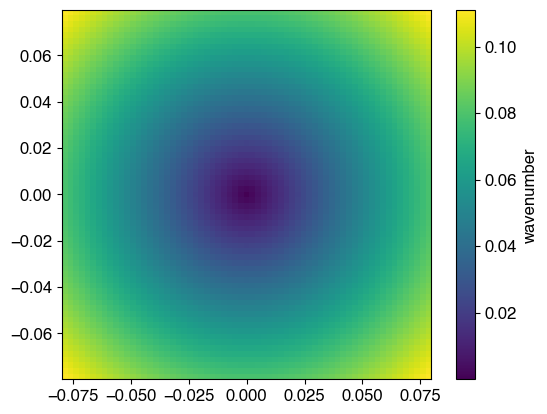

In [133]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(wave_number_east, wave_number_north, k)
ax.set_aspect('equal')
cb = fig.colorbar(pcm)
cb.set_label('wavenumber')

The mapping is

$$
E(\omega, \theta) = \Psi(\mathbf{k}) k \frac{dk}{d\omega}
$$

where $ \frac{dk}{d\omega}$ is the Jacobian equal to the inverse of the group velocity, $ \frac{dk}{d\omega} = 1 / c_g$

In [134]:
print(k.min())
cg1 = intrinsic_group_velocity(k.min(), depth=1000000000)
w = np.sqrt(9.81 * k.min())
cg2 = 0.5 * 9.81 / w
print(cg1)
print(cg2)

<xarray.DataArray ()>
array(1.13137082e-08)
<xarray.DataArray ()>
array(14723.19365278)
<xarray.DataArray ()>
array(14723.19355573)


In [135]:
mean_area = np.outer(np.diff(wave_number_east.values),
                     np.diff(wave_number_north.values)).mean()  # rad^2/m^2
energy_density = average_energy / mean_area  # m^4/rad^2
jacobian = 1/intrinsic_group_velocity(k, depth=1000)
energ_freq_dir = energy_density * k * jacobian
angular_frequency_east = intrinsic_dispersion_relation(wave_number_east[wave_number_east > 0],  depth=1000)
angular_frequency_north = intrinsic_dispersion_relation(wave_number_north[wave_number_north > 0],  depth=1000)

/opt/homebrew/Caskroom/miniconda/base/envs/PyWSRA/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: overflow encountered in sinh
  result_data = func(*input_data)


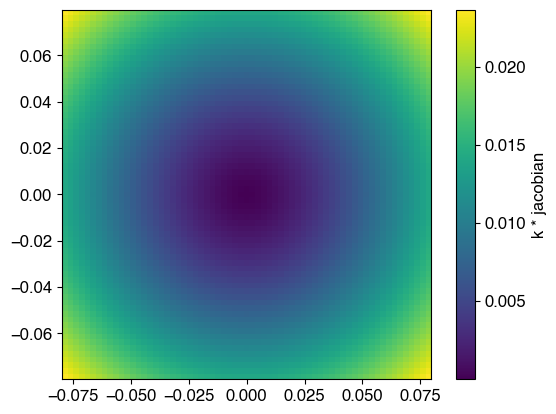

In [136]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(wave_number_east, wave_number_north, k * jacobian)
ax.set_aspect('equal')
cb = fig.colorbar(pcm)
cb.set_label('k * jacobian')

In [137]:
theta = np.arctan2(ky, kx)  # TODO: swap for met conv?
theta_met_deg = (-(theta  * 180/np.pi) + 90) % 360
theta_met_rad = theta_met_deg * np.pi/180

In [138]:
# positive_indices = wave_number_east >= 0
# wave_number_east_pos = intrinsic_dispersion_relation(wave_number_east[positive_indices])
# wave_number_east_neg = intrinsic_dispersion_relation(np.abs(wave_number_east[~positive_indices]))

# angular_frequency_east = np.concatenate([wave_number_east_neg, wave_number_east_pos])

angular_frequency_east = np.where(wave_number_east >= 0,
                                  intrinsic_dispersion_relation(wave_number_east),
                                  -intrinsic_dispersion_relation(np.abs(wave_number_east)))
angular_frequency_north = np.where(wave_number_north >= 0,
                                  intrinsic_dispersion_relation(wave_number_north),
                                  -intrinsic_dispersion_relation(np.abs(wave_number_north)))

angular_frequency = intrinsic_dispersion_relation(k)

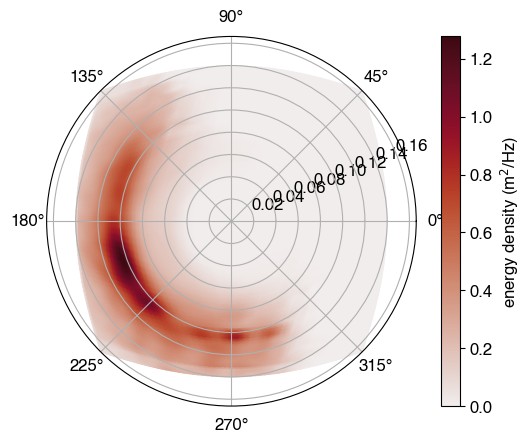

In [139]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
cmap = cmocean.cm.amp
cmap.set_under('white')
pcm = ax.pcolormesh(theta,
                    angular_frequency/(2*np.pi),
                    energ_freq_dir,
                    shading='gouraud',
                    # norm=mpl.colors.LogNorm(vmin=1*10**(-2), vmax=1*10**(1)))
                    cmap=cmap)
# ax.set_theta_direction(-1)
# ax.set_theta_offset(np.pi / 2.0)
cb = fig.colorbar(pcm)
cb.set_label('energy density (m$^2$/Hz)')


In [140]:
#TODO: interpolate onto an f, theta grid

#TODO: interpolation has to happen in k-space?

In [141]:
angular_frequencies = intrinsic_dispersion_relation(wave_number_north[wave_number_north > 0])

In [142]:
direction_step = 1
directions = np.deg2rad(np.arange(0, 360 + direction_step, direction_step))

directions_met_deg = (-(directions  * 180/np.pi) + 90) % 360
directions_met_rad = directions_met_deg * np.pi/180


In [143]:
angular_frequency_grid, direction_grid = np.meshgrid(angular_frequencies, directions_met_rad )  # directions_met_rad)

In [144]:
frequency_direction_x = angular_frequency_grid * np.sin(direction_grid)  # met directions
frequency_direction_y = angular_frequency_grid * np.cos(direction_grid)

/var/folders/5k/tj9m5nbs0rb__4sp5qh876yc0000gn/T/ipykernel_11275/2276908153.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(frequency_direction_x, frequency_direction_y, angular_frequency_grid)


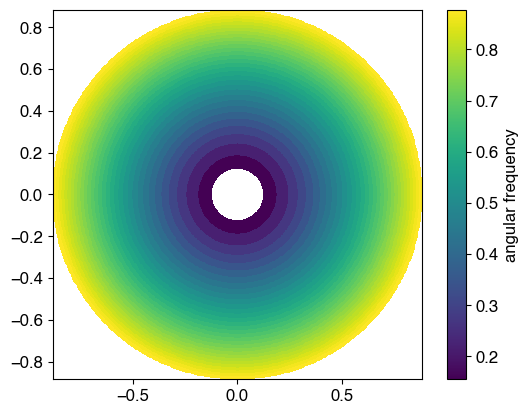

In [145]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(frequency_direction_x, frequency_direction_y, angular_frequency_grid)
ax.set_aspect('equal')
cb = fig.colorbar(pcm)
cb.set_label('angular frequency')

In [146]:
wavenumber_grid = dispersion_solver(frequency=angular_frequency_grid/(2*np.pi),
                                    depth = 1*10**3)


In [147]:
print(wavenumber_grid.min())
print(wave_number_north[wave_number_north > 0].min())

0.002488444224254161
<xarray.DataArray 'wavenumber_north' ()>
array(0.00245436)


/var/folders/5k/tj9m5nbs0rb__4sp5qh876yc0000gn/T/ipykernel_11275/539631717.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(frequency_direction_x, frequency_direction_y, wavenumber_grid)


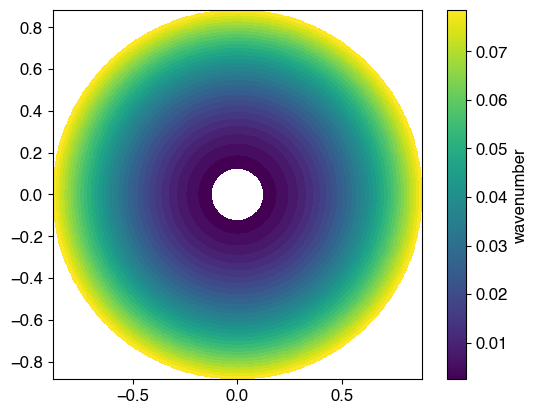

In [148]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(frequency_direction_x, frequency_direction_y, wavenumber_grid)
ax.set_aspect('equal')
cb = fig.colorbar(pcm)
cb.set_label('wavenumber')

In [149]:
wavenumber_direction_x = wavenumber_grid * np.sin(direction_grid)  # met directions
wavenumber_direction_y = wavenumber_grid * np.cos(direction_grid)

/var/folders/5k/tj9m5nbs0rb__4sp5qh876yc0000gn/T/ipykernel_11275/3235811815.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(wavenumber_direction_x, wavenumber_direction_y, wavenumber_grid)


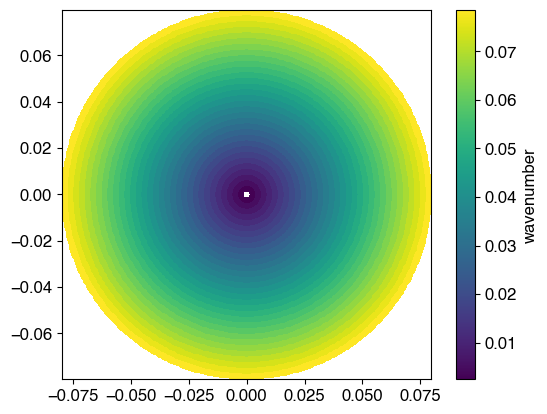

In [150]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(wavenumber_direction_x, wavenumber_direction_y, wavenumber_grid)
ax.set_aspect('equal')
cb = fig.colorbar(pcm)
cb.set_label('wavenumber')

In [151]:
interp = scipy.interpolate.RegularGridInterpolator((wave_number_east, wave_number_north), energy_density)  # TODO: why .T?
energy_density_grid = interp((wavenumber_direction_x, wavenumber_direction_y))
#TODO: outdated
# interpolator = scipy.interpolate.interp2d(angular_frequency_east, angular_frequency_north, energ_freq_dir, kind='linear', bounds_error=True, fill_value='nan')
# Z = interpolator(frequency_direction_x, frequency_direction_y)

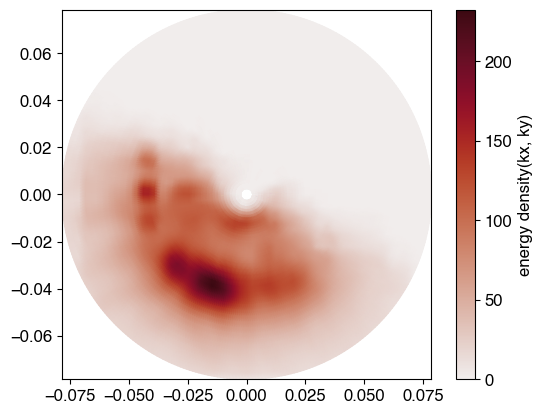

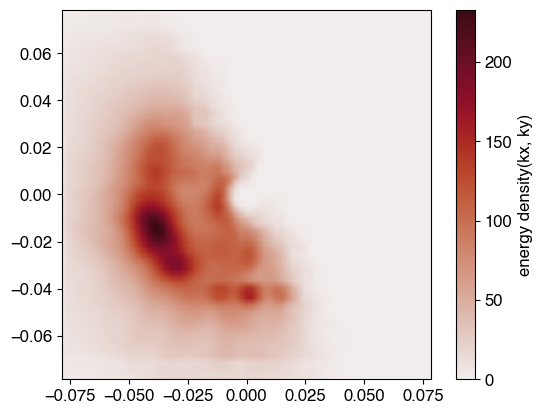

In [152]:
cmap = cmocean.cm.amp
cmap.set_under('white')

fig, ax = plt.subplots()
pcm = ax.pcolormesh(wavenumber_direction_x,  # angular_frequency_east,
                    wavenumber_direction_y, # angular_frequency_north,
                    energy_density_grid,
                    cmap=cmap,
                    shading='gouraud',
                    # norm=mpl.colors.LogNorm(vmin=1*10**(-2), vmax=1*10**(1))
                    )
ax.set_aspect('equal')
cb = fig.colorbar(pcm)
cb.set_label('energy density(kx, ky)')

fig, ax = plt.subplots()
pcm = ax.pcolormesh(wave_number_east,
                    wave_number_north,
                    energy_density,
                    cmap=cmap,
                    shading='gouraud',
                    # norm=mpl.colors.LogNorm(vmin=1*10**(-2), vmax=1*10**(1))
                    )
ax.set_aspect('equal')
cb = fig.colorbar(pcm)
cb.set_label('energy density(kx, ky)')

# ax.scatter(frequency_direction_x, frequency_direction_y)


Now convert back to freq direction

In [153]:
jacobian = 1/intrinsic_group_velocity(wavenumber_grid, depth=1000)
energ_freq_dir_grid = energy_density_grid * wavenumber_grid * jacobian

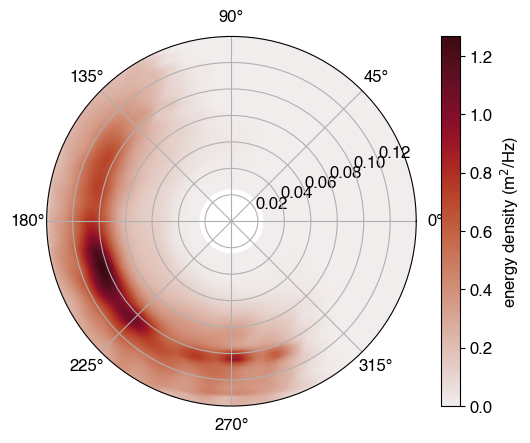

In [154]:

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
cmap = cmocean.cm.amp
cmap.set_under('white')
pcm = ax.pcolormesh(direction_grid,
                    angular_frequency_grid/(2*np.pi),
                    energ_freq_dir_grid,
                    shading='gouraud',
                    # norm=mpl.colors.LogNorm(vmin=1*10**(-2), vmax=1*10**(1)))
                    cmap=cmap)
cb = fig.colorbar(pcm)
cb.set_label('energy density (m$^2$/Hz)')

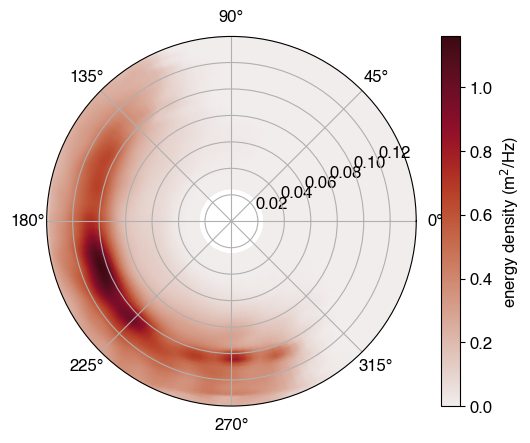

In [155]:
energy_density_freq, direction, angular_frequency = pywsra.wn_spectrum_to_fq_spectrum(
    energy=average_energy,
    wavenumber_east=wave_number_east,
    wavenumber_north=wave_number_north,
    depth=50
)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
cmap = cmocean.cm.amp
cmap.set_under('white')
pcm = ax.pcolormesh(direction,
                    angular_frequency/(2*np.pi),
                    energy_density_freq,
                    shading='gouraud',
                    # norm=mpl.colors.LogNorm(vmin=1*10**(-2), vmax=1*10**(1)))
                    cmap=cmap)
cb = fig.colorbar(pcm)
cb.set_label('energy density (m$^2$/Hz)')


Now integrate

In [156]:
energ_freq_dir_grid.shape

(361, 32)

In [157]:
# angular_frequencies, directions_met_rad
# energ_freq_dir_grid
energy_freq = np.trapz(energ_freq_dir_grid, axis=0) * np.deg2rad(direction_step)

Compare

In [158]:
swift_ds_in_mission['energy'].mean(axis=1)

<xarray.DataArray 'energy' (freq: 42)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan])
Coordinates:
  * freq     (freq) float64 0.009766 0.02148 0.0332 ... 0.4668 0.4785 0.4902

Text(0.5, 0, 'frequency (Hz)')

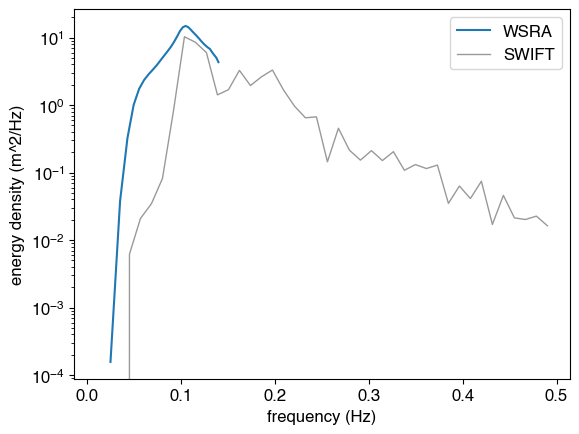

In [159]:
swift_ds_in_mission = swift_ds_matches.where(swift_ds_matches['ymd'] == ymd)
swift_ds_in_mission

fig, ax = plt.subplots()
ax.plot(angular_frequencies/(2*np.pi), energy_freq * (2*np.pi), label='WSRA')
ax.plot(swift_ds_in_mission['freq'], swift_ds_in_mission['energy'].mean(axis=1), color='k', linewidth=1, alpha=0.4, label='SWIFT')
ax.legend()
ax.set_yscale('log')``
ax.set_ylabel('energy density (m^2/Hz)')
ax.set_xlabel('frequency (Hz)')

In [269]:
in_circle = k >= wave_number_east.max()  # Mask outside polar region (to account for variance)

energy_density_circle = energy_density.copy()
energy_density_circle[in_circle] = 0

energy_density_int_x = np.trapz(energy_density_circle, x=wave_number_east, axis=0)
variance_wavenumber_spectrum = np.trapz(energy_density_int_x, x=wave_number_north, axis=0)

variance_frequency_spectrum = np.trapz(energy_freq, x=angular_frequencies)


print(variance_wavenumber_spectrum)
print(variance_frequency_spectrum)


0.64427626
0.6449447965288346


TypeError: Dimensions of C (361, 32) should be one smaller than X(65) and Y(65) while using shading='flat' see help(pcolormesh)

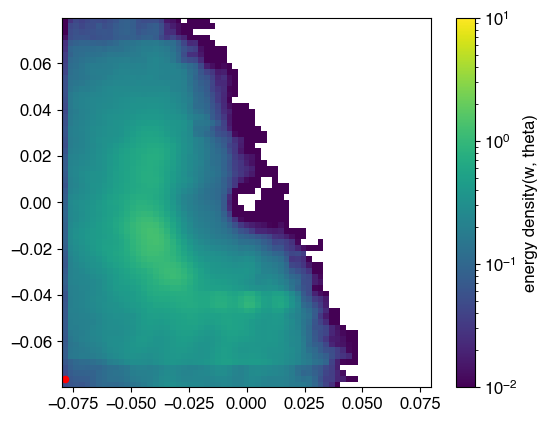

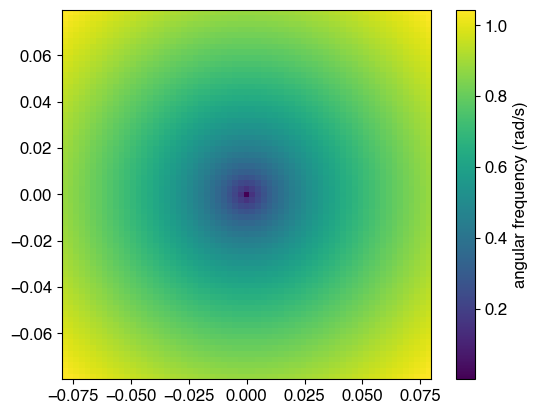

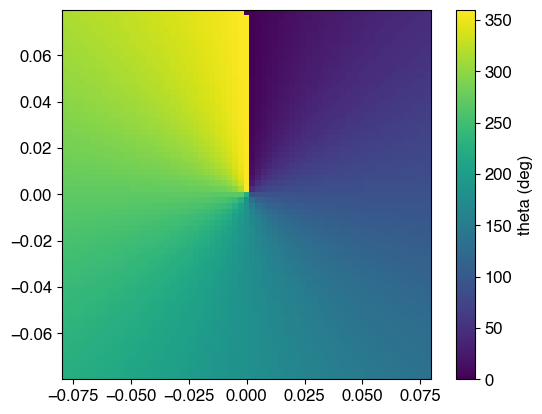

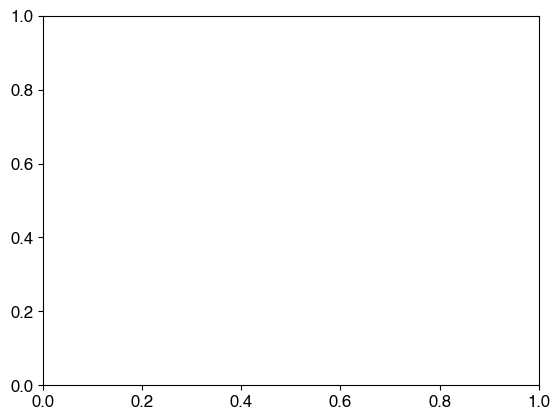

In [202]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(wave_number_east,  # angular_frequency_east,
                    wave_number_north, # angular_frequency_north,
                    energ_freq_dir,
                    norm=mpl.colors.LogNorm(vmin=1*10**(-2), vmax=1*10**(1)))
ax.set_aspect('equal')
cb = fig.colorbar(pcm)
cb.set_label('energy density(w, theta)')
i = 1
j = 0
ax.scatter(kx[i, j],
           ky[i, j], color='r', s=20)


fig, ax = plt.subplots()
pcm = ax.pcolormesh(wave_number_east, wave_number_north, angular_frequency)
ax.set_aspect('equal')
cb = fig.colorbar(pcm)
cb.set_label('angular frequency (rad/s)')


fig, ax = plt.subplots()
pcm = ax.pcolormesh(wave_number_east, wave_number_north, theta_met_deg)
ax.set_aspect('equal')
cb = fig.colorbar(pcm)
cb.set_label('theta (deg)')

fig, ax = plt.subplots()
pcm = ax.pcolormesh(kx, ky, jacobian)
ax.set_aspect('equal')
cb = fig.colorbar(pcm)
cb.set_label('jacobian')




#### ERA5 comparison

In [ ]:
localfolderbase = f'../data/ERA5/ATOMIC/'

# get extent:
#NOTE: could do a moving box but the whole area is probably better for animations
minLat = currentTrack['LAT'].min()
maxLat = currentTrack['LAT'].max()
maxLon = currentTrack['LON'].max()
minLon = currentTrack['LON'].min()

area  = models.get_ERA5_extent(lats = [minLat,maxLat],
                                lons = [minLon,maxLon])

# increase area by approx 400 km (215 nm) or ~3.75 deg:
area = list(np.array(area)+ 3.75*np.array([1, -1, -1, 1]))

# visual
fig,ax = plt.subplots(1,1)
ax.plot(currentTrack['LON'],currentTrack['LAT'],'k')
ax.axhline(area[0])
ax.axhline(area[2])
ax.axvline(area[1])
ax.axvline(area[3])
ax.set_title(storm)
plt.show()

# generate daterange:
start = currentTrack.index[0]
end   = currentTrack.index[-1] 
daterange = models.generate_ERA5_daterange(startDate = start,
                                            endDate = end,
                                            interval='days')

for date in daterange:
    years, months, days, _ = models.get_ERA5_ymdh([date])
    hours = 'all'

    for vars in ['wind_vars', 'wave_vars_reduced']:
        # get vars
        ERA5_vars = models.get_ERA5_variables(keys = [vars])

        # generate an API request in dictionary format:
        requestDict = models.generate_ERA5_API_request_dict(ERA5_vars,
                                                                year=years, 
                                                                month=months, 
                                                                day=days, 
                                                                time=hours, 
                                                                area=area)

        #% generate filename:
        requestFilename = models.generate_ERA5_API_request_filename(requestDict, postfix = '_' + vars)
        
        # Submit the request:
        models.ERA5_API_request(localfolderbase + requestFilename, requestDict)

#%% check
filename = requestFilename
filename = 'ERA5_reanalysis_[41.25, -66.5, 26.25, -48.5]_20210524_wind_vars'
ERA5 = models.read_ERA5_gribfile(localfolderbase + filename + '.grib')



In [ ]:
#TODO: 
# - plot wave slopes
# - plot HDG and wave direction
# - plot indivual track lines

### References

Pincus, Robert, Chris W. Fairall, Adriana Bailey, Haonan Chen, Patrick Y. Chuang, Gijs De Boer, Graham Feingold, et al. 2021. “Observations from the NOAA P-3 Aircraft during ATOMIC.” Earth System Science Data 13 (7): 3281–96. https://doi.org/10.5194/essd-13-3281-2021.

Quinn, Patricia K., Elizabeth Thompson, Derek J. Coffman, Sunil Baidar, Ludovic Bariteau, Timothy S. Bates, Sebastien Bigorre, et al. 2020. “Measurements from the &lt;I&gt;RV Ronald H. Brown&lt;/I&gt; and Related Platforms as Part of the Atlantic Tradewind Ocean-Atmosphere Mesoscale Interaction Campaign (ATOMIC).” Preprint. Oceanography – Physical. https://doi.org/10.5194/essd-2020-331.


In [ ]:
# atomic_swifts_concat = xr.concat(
#     [atomic_swifts[swift_id].drop_dims('zHR', errors = "ignore")\
#                                         for swift_id in atomic_swifts.keys()],
#      dim='time'
# ).sortby('time')

In [ ]:
# swift_ids = [re.search('SWIFT[0-9]{2}', file).group() for file in filenames]
# xr.concat(atomic_swifts, pd.Index(swift_ids, name='id'), coords='minimal')

In [ ]:
# Plot co-located measurements in space
# def plot_wsra_and_swift(wsra_ds, swift_ds, wsra_var, swift_var, extent, cmap, norm):
#     gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace = .35)
#     ax1 = fig.add_subplot(gs[0], projection=PROJECTION)
#     ax2 = fig.add_subplot(gs[1])

#     divider = make_axes_locatable(ax1)
#     cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes, pad="2%")

#     wsra_ds.wsra.chart.ocean_color = 'white' # 'whitesmoke'
#     wsra_ds.wsra.chart.land_color = 'floralwhite'  # white, whitesmoke

#     wsra_ds.wsra.plot(
#         extent=extent,
#         column=wsra_var,
#         plot_best_track=False,
#         legend=True,
#         marker='.',
#         label='WSRA',
#         cmap=cmap,
#         norm=norm,
#         ax=ax1,
#         cax=cax,
#         legend_kwds={
#             "orientation": "vertical",
#             "location": "left",
#         }
#     )

#     ax1.scatter(
#         swift_ds['lon'],
#         swift_ds['lat'],
#         c=swift_ds[swift_var],
#         s=5,
#         marker='d',
#         label='SWIFT',
#         cmap=cmap,
#         norm=norm,
#     )

#     ax2.scatter(
#         wsra_ds[wsra_var],
#         swift_ds[swift_var],
#         color='k',
#         s=5,
#     )

#     return ax1, ax2, cax
# for swift_id in ['SWIFT23']:  #atomic_swifts.keys():  # ['SWIFT23']:  #atomic_swifts.keys():

    # matching_wsra_indices, matching_path_indices = colocate_with_path(
    #     wsra_ds = atomic_wsra.wsra.mask(),
    #     path_ds = atomic_swifts[swift_id],
    #     path_vars = ('time', 'lat', 'lon', 'sea_surface_wave_mean_square_slope_normalized_by_frequency_width'),
    #     wsra_vars = ('time', 'latitude', 'longitude'),
    #     temporal_tolerance = np.timedelta64(60, 'm'),
    #     spatial_tolerance = 55,  #km
    # )

    # wsra_ds_matches = atomic_wsra.isel(trajectory=matching_wsra_indices)
    # swift_ds_matches = atomic_swifts[swift_id].isel(time=matching_path_indices)

    # fig = plt.figure(figsize=(14, 6))
    # ax1, ax2, cax = plot_wsra_and_swift(
    #     wsra_ds=wsra_ds_matches,  #.where(wsra_ds_matches.longitude > -53),
    #     swift_ds=swift_ds_matches, #.where(swift_ds_matches.lon > -53),
    #     wsra_var='sea_surface_wave_significant_height',
    #     swift_var='sea_surface_wave_significant_height',
    #     extent=(-56, -51, 13.5, 16),  # (x0, x1, y0, y1)
    #     cmap=mpl.cm.plasma,
    #     norm=mpl.colors.Normalize(vmin=0, vmax=8),
    # )

    # # ax1.plot(atomic_ship['lon'], atomic_ship['lat'])

    # ax1.set_title(f"{swift_id}")
    # ax1.legend(loc='lower right')
    # cax.set_ylabel('significant wave height (m)')
    # ax2.set_xlabel('WSRA significant wave height (m)')
    # ax2.set_ylabel('SWIFT significant wave height (m)')
    # ax2.set_xlim([0, 8])
    # ax2.set_ylim([0, 8])
    # ax2.set_aspect('equal')
    
    # fig.savefig(f'{swift_id}_and_WSRA_significant_wave_height.{IMAGE_FILE_TYPE}',
    #             format=IMAGE_FILE_TYPE,
    #             dpi=IMAGE_RESOLUTION)

    # fig = plt.figure(figsize=(14, 6))
    # ax1, ax2, cax = plot_wsra_and_swift(
    #     wsra_ds=wsra_ds_matches,
    #     swift_ds=atomic_swifts[swift_id].isel(time=matching_path_indices),
    #     wsra_var='sea_surface_mean_square_slope_median',
    #     swift_var='mean_square_slope',
    #     extent=(-56, -51, 13.5, 16),  # (x0, x1, y0, y1)
    #     cmap=cmocean.cm.turbid,
    #     norm=mpl.colors.Normalize(vmin=0, vmax=0.08),
    # )

    # ax1.set_title(f"{swift_id}")
    # ax1.legend(loc='lower right')
    # cax.set_ylabel('mean square slope (-)')
    # ax2.set_xlabel('WSRA mean square slope (-)')
    # ax2.set_ylabel('SWIFT mean square slope (-)')
    # ax2.set_xlim([0, 0.08])
    # ax2.set_ylim([0, 0.08])
    # ax2.set_aspect('equal')

